# Import libraries

In [1]:
import pandas as pd
import time
import sys

import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import seaborn as sns
sns.set(style="darkgrid", rc = {'figure.figsize':(5,7)})
import matplotlib.pyplot as plt

# Define parameters

In [2]:
# Main path
root_path = r"C:\Users\Sonita\Documents\KU_Leuven\Subjects\2022-1\Modern Data Analytics\5. New_Project\github"

# Path for data
data_path = root_path + r"\data"

# Path for codes
code_path = root_path + r"\code"

# Path for outputs
output_path = root_path + r"\output"

# Define random state for reproducibility
random_state = 0

# Define colors to use in plots
colors = ["#00cfcc","#e6013b","#007f88","#00cccd","#69e0da","darkblue"]

# Import my functions module

In [3]:
sys.path.append(code_path)

from my_functions import kruskall_relation

# Read data

In [4]:
start_time = time.time()

# Read processed data
filt_whole_df = pd.read_csv(output_path + "\\" + "4.filt_year_processed_df.csv", sep=";", encoding="latin1")

# Read features dictionary
features_diccionary = pd.read_csv(data_path + "\\" + "features_diccionary.csv", sep=";")

print("Execution time:", time.time() - start_time, " seconds")

Execution time: 0.03199911117553711  seconds


# Clustering

## Feature importance

In [5]:
# Get list with all analyzable variables
all_vars = filt_whole_df.columns
all_vars = [i for i in all_vars if
            i not in ['Year', 'Country_code', 'Mean_temperature', 'Min_temperature', 'Max_temperature', 'Country'
                    , 'Country_code3', 'High_temperature', 'Heat_wave', 'Days_w_High_temperature'
                    , 'Days_w_Heat_wave', 'Country_cross']]

# Get ranking of features vs heat wave
ranking_heat_wave = kruskall_relation(data=filt_whole_df, vars=all_vars)

# Export results
ranking_heat_wave.to_csv(output_path + "\\" + '6.features_ranking_heat_wave.csv', index=False, sep=";")

100%|██████████| 163/163 [00:00<00:00, 543.22it/s]


In [6]:
ranking_heat_wave.head(10)

,variable,pvalue,-logpval
21,Rat-Pre-Bot-Car_dis,0.003041,5.795542
20,Per-Pre-Bot-Car_dis,0.003235,5.733723
33,Rat-Pre-Bot-Dia_and_kid_dis,0.007762,4.858464
32,Per-Pre-Bot-Dia_and_kid_dis,0.007829,4.849927
116,Per-YLD-Bot-Res_inf_and_tub,0.008100,4.815854
18,Rat-Pre-Bot-Neo,0.010545,4.552137
78,Rat-Dea-Bot-Neu_dis,0.010761,4.531873
17,Per-Pre-Bot-Neo,0.010833,4.525128
147,Rat-YLD-Bot-Dig_dis,0.021065,3.860139
123,Rat-YLD-Bot-Car_dis,0.033680,3.390847


## Hierarchical clustering

In [7]:
# Select variables to include
vars_selected = ['Rat-Pre-Bot-Car_dis', 'Rat-Pre-Bot-Dia_and_kid_dis', 'Per-YLD-Bot-Res_inf_and_tub', 'Rat-Pre-Bot-Neo'
               , 'Rat-Dea-Bot-Neu_dis', 'Rat-YLD-Bot-Dig_dis', 'Rat-YLD-Bot-Car_dis', 'Rat-YLD-Bot-Dia_and_kid_dis'
               , 'Per-YLD-Bot-Ski_and_sub_dis', 'Per-Dea-Bot-Res_inf_and_tub', 'Rat-Dea-Bot-Mal_ski_mel', 'Per-Pre-Bot-Sub_use_dis'
               , 'Per-YLD-Bot-Chr_res_dis', 'Per-YLD-Bot-Men_dis', 'Heat_wave']

# Select data to use in clustering
selected_data = filt_whole_df[filt_whole_df['Year'] == 2000]
only_features = selected_data[vars_selected]

# Quantiles for Robust normalization
q25 = only_features.quantile(0.25).values
q50 = only_features.quantile(0.50).values
q75 = only_features.quantile(0.75).values

# Transform data
only_features = pd.DataFrame((only_features.values - q50) / (q75 - q25))
only_features.columns = vars_selected

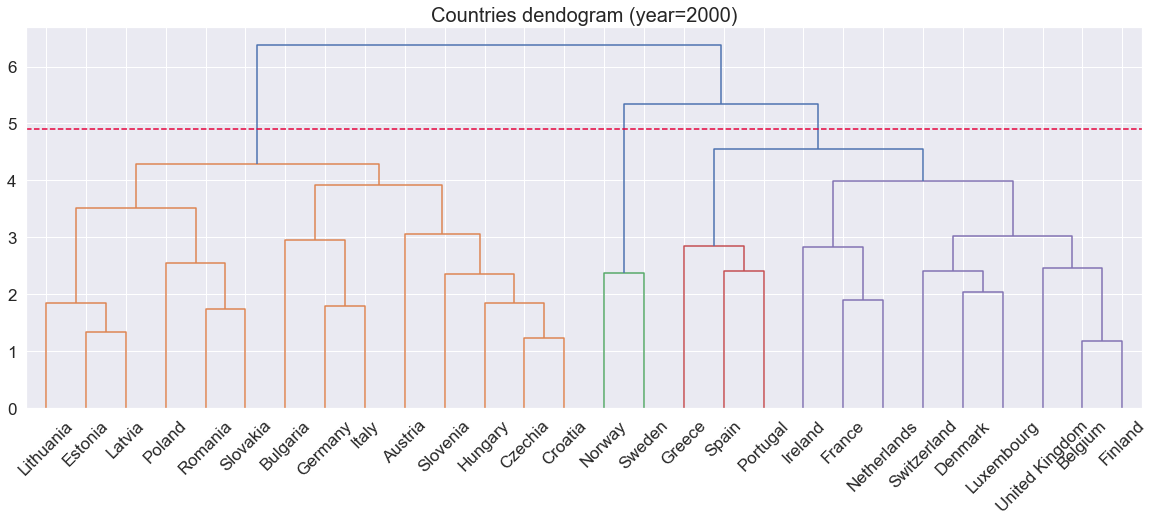

In [8]:
# Fit hierarchical clustering
clusters = shc.linkage(only_features, method='complete',  metric="euclidean")

# Plot dendogram
plt.figure(figsize=(20, 7))
plt.title("Countries dendogram (year=2000)",fontsize=20)
shc.dendrogram(Z=clusters, labels = list(selected_data['Country']))
plt.tick_params(labelsize=17)
plt.axhline(y = 4.9, color = colors[1], linestyle = '--')
plt.show()

In [9]:
# Run clustering to get predictions
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'complete')

# Predict clusters
cluster_pred = hc.fit_predict(only_features)

# Concatenate data and cluster
selected_data = pd.concat([selected_data.reset_index(drop=True),pd.DataFrame(cluster_pred).reset_index(drop=True)], axis=1)
selected_data.columns = [*selected_data.columns[:-1], 'cluster_HC']

# Calculate silhouette_score to make comparissons
score_HC = silhouette_score(only_features, selected_data.cluster_HC, metric='euclidean')
print("\nSilhouette score:", score_HC)

# Get variable by cluster to characterize
charact_clus_HC = selected_data[['cluster_HC'] + vars_selected].groupby('cluster_HC').mean().reset_index()
charact_clus_HC


Silhouette score: 0.2029190102499568


,cluster_HC,Rat-Pre-Bot-Car_dis,Rat-Pre-Bot-Dia_and_kid_dis,Per-YLD-Bot-Res_inf_and_tub,Rat-Pre-Bot-Neo,Rat-Dea-Bot-Neu_dis,Rat-YLD-Bot-Dig_dis,Rat-YLD-Bot-Car_dis,Rat-YLD-Bot-Dia_and_kid_dis,Per-YLD-Bot-Ski_and_sub_dis,Per-Dea-Bot-Res_inf_and_tub,Rat-Dea-Bot-Mal_ski_mel,Per-Pre-Bot-Sub_use_dis,Per-YLD-Bot-Chr_res_dis,Per-YLD-Bot-Men_dis,Heat_wave
0,0,10676.096523,13470.177391,0.008838,14599.453232,42.391884,356.137886,702.137341,592.986078,0.038045,0.024772,2.802761,0.035913,0.031865,0.141520,0.785714
1,1,9369.038479,11727.291489,0.008659,10530.516221,52.314960,242.005417,478.572416,471.900199,0.054807,0.048787,3.123352,0.040257,0.049223,0.167243,0.000000
2,2,11257.435164,12730.046536,0.009061,13703.638103,64.680558,292.642078,662.102536,514.539936,0.051695,0.047518,5.131686,0.032994,0.058164,0.159821,0.000000
3,3,8959.404181,13512.914772,0.008692,9614.477403,47.410303,193.102793,529.222498,691.207919,0.052944,0.038924,1.862982,0.035802,0.043615,0.180746,0.333333


## K-means clustering

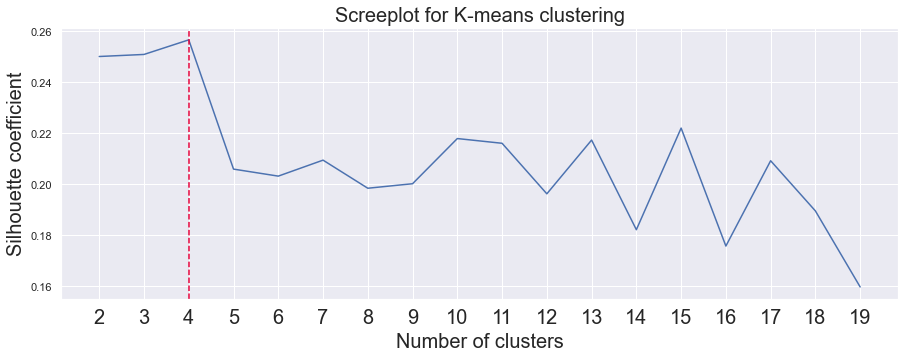

In [10]:
# Define parameters for k-means
kmeans_kwargs = { "init": "k-means++", "n_init": 10, "max_iter": 500, "random_state": random_state}

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Loop to get best number of groups
for k in range(2, 20):
    # Define K-means
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)

    # Fit K-means
    kmeans.fit(only_features)

    # Calculate Silhouette score
    score = silhouette_score(only_features, kmeans.labels_)
    silhouette_coefficients.append(score)

# Plot Silhouette score to get best number of clusters
plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), silhouette_coefficients)
plt.title("Screeplot for K-means clustering",fontsize=20)
plt.xticks(range(2, 20), fontsize = 20)
plt.xlabel("Number of clusters", fontsize = 20)
plt.ylabel("Silhouette coefficient", fontsize = 20)
plt.axvline(x = 4, color = colors[1], linestyle = '--')
plt.show()

In [11]:
# Fit k-Means
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)

# Predict clusters
cluster_pred = kmeans.fit_predict(only_features)

# # Concatenate data and cluster
selected_data = pd.concat([selected_data.reset_index(drop=True),pd.DataFrame(cluster_pred).reset_index(drop=True)], axis=1)
selected_data.columns = [*selected_data.columns[:-1], 'cluster_KM']

# Remap values of clusters to get numbers by heat wave percentage
aux_cluster = selected_data[['cluster_KM', 'Heat_wave']].groupby('cluster_KM').mean().reset_index().sort_values(by = 'Heat_wave').reset_index(drop=True)
convert_clust = {list(aux_cluster.cluster_KM)[i]: (list(aux_cluster.index)[i] + 1) for i in range(len(list(aux_cluster.cluster_KM)))}
selected_data.replace({"cluster_KM": convert_clust}, inplace = True)

# Calculate silhouette_score to make comparissons
score_KM = silhouette_score(only_features, selected_data.cluster_KM, metric='euclidean')
print("\nSilhouette score:", score_KM)

# Get variable by cluster to characterize
charact_clus_KM = selected_data[['cluster_KM'] + vars_selected].groupby('cluster_KM').mean().reset_index()
aux_cant = selected_data.cluster_KM.value_counts().reset_index().sort_values(by='index').reset_index(drop=True)
aux_cant.columns = ['cluster_KM','num_countries']

charact_clus_KM = pd.concat([charact_clus_KM, aux_cant['num_countries']], axis = 1)
charact_clus_KM


Silhouette score: 0.25668976175089414


,cluster_KM,Rat-Pre-Bot-Car_dis,Rat-Pre-Bot-Dia_and_kid_dis,Per-YLD-Bot-Res_inf_and_tub,Rat-Pre-Bot-Neo,Rat-Dea-Bot-Neu_dis,Rat-YLD-Bot-Dig_dis,Rat-YLD-Bot-Car_dis,Rat-YLD-Bot-Dia_and_kid_dis,Per-YLD-Bot-Ski_and_sub_dis,Per-Dea-Bot-Res_inf_and_tub,Rat-Dea-Bot-Mal_ski_mel,Per-Pre-Bot-Sub_use_dis,Per-YLD-Bot-Chr_res_dis,Per-YLD-Bot-Men_dis,Heat_wave,num_countries
0,1,11014.128113,12172.574520,0.008863,12669.324711,61.234990,282.000115,606.161032,469.673591,0.053368,0.041884,4.897581,0.036611,0.056007,0.157109,0.000000,3
1,2,9152.004077,12275.157930,0.008685,10274.307298,50.792881,226.967359,490.958293,540.071331,0.054126,0.047749,2.660886,0.038716,0.047469,0.172340,0.090909,11
2,3,9781.203852,12838.012939,0.009745,14417.502660,38.691752,362.481792,692.194671,473.874149,0.034732,0.027123,2.457718,0.037623,0.027740,0.142146,0.500000,6
3,4,11347.266027,13944.300729,0.008158,14735.916162,45.166983,351.379956,709.594343,682.320024,0.040529,0.023008,3.061543,0.034631,0.034959,0.141051,1.000000,8


## Characterizing with best method (K-Means)

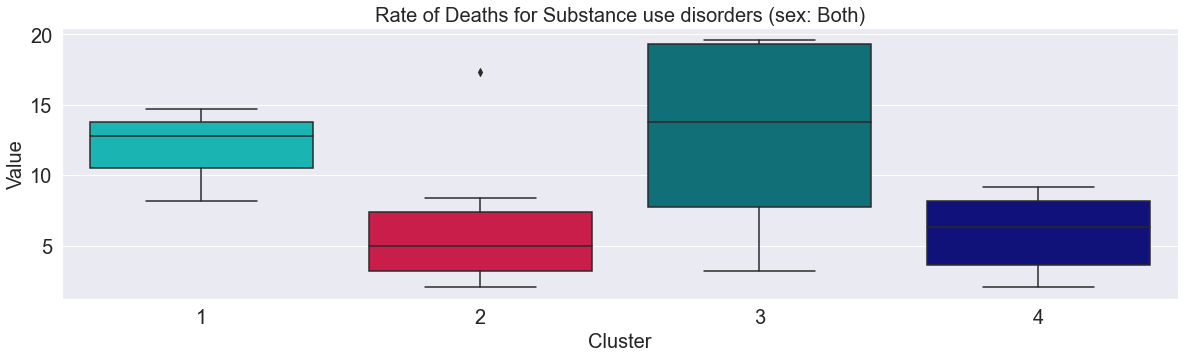

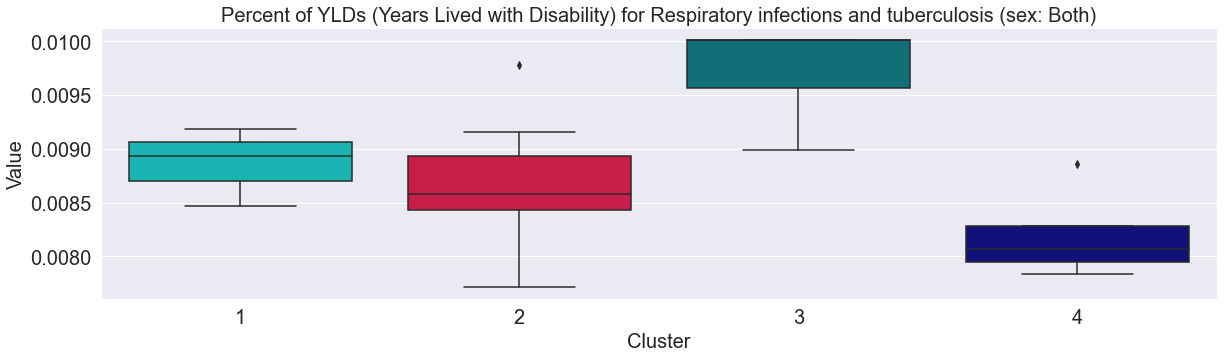

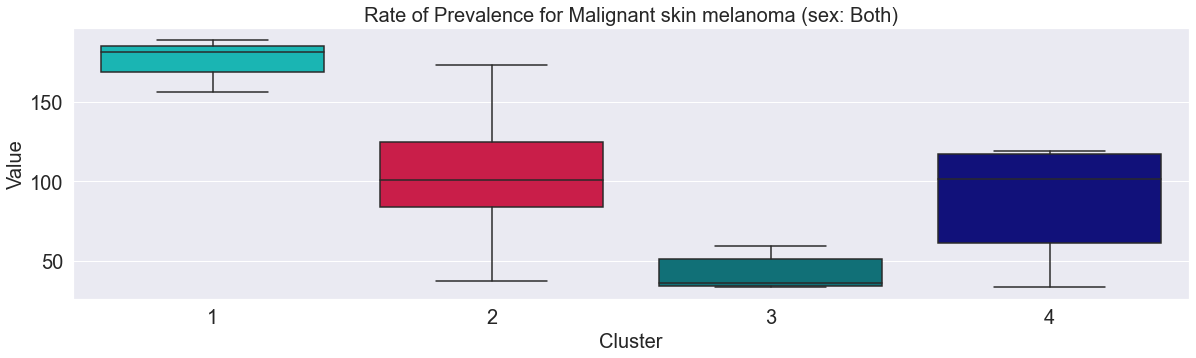

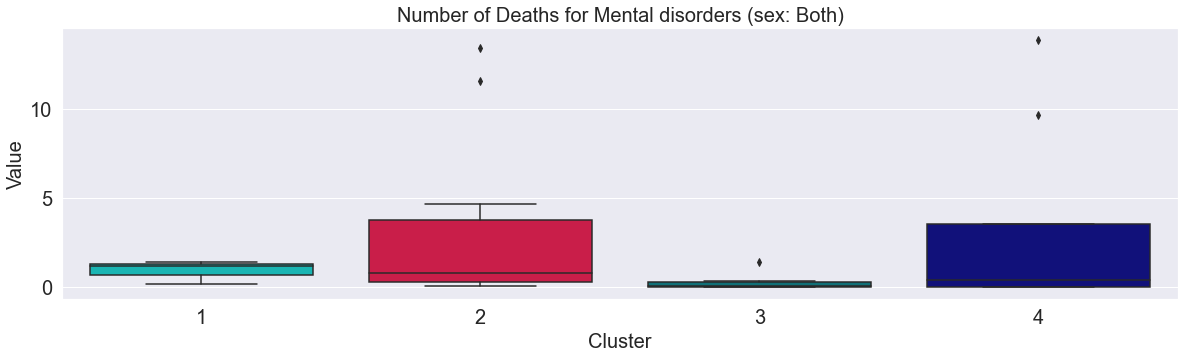

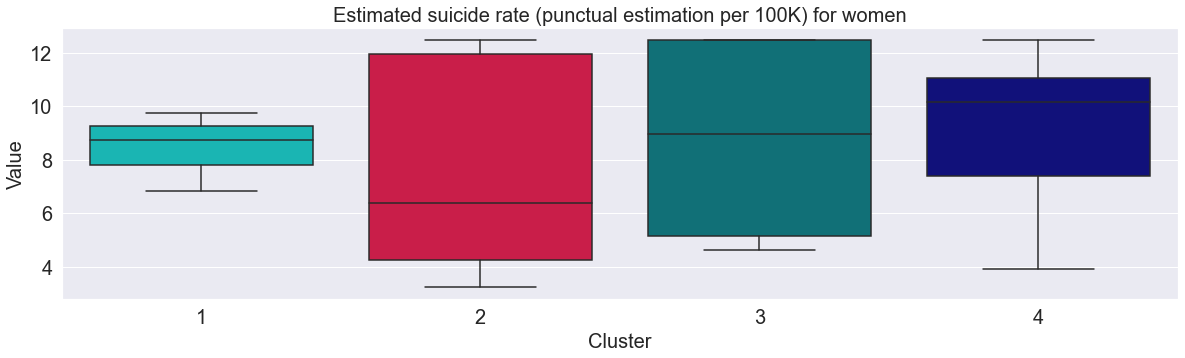

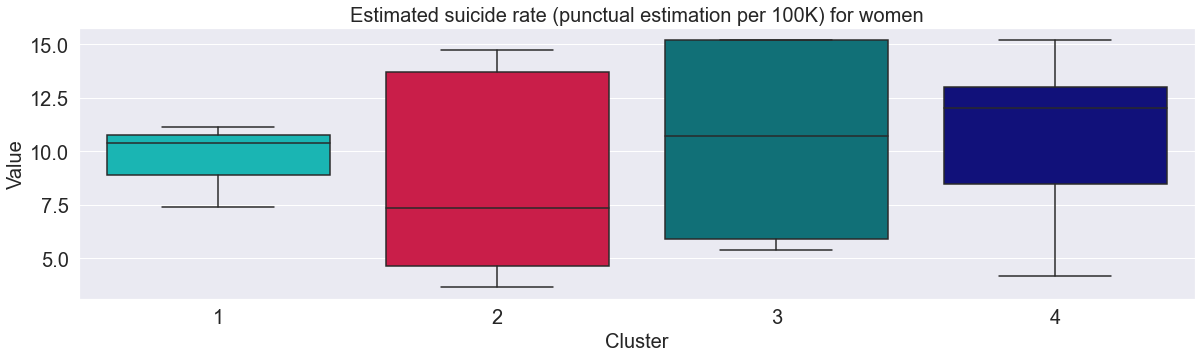

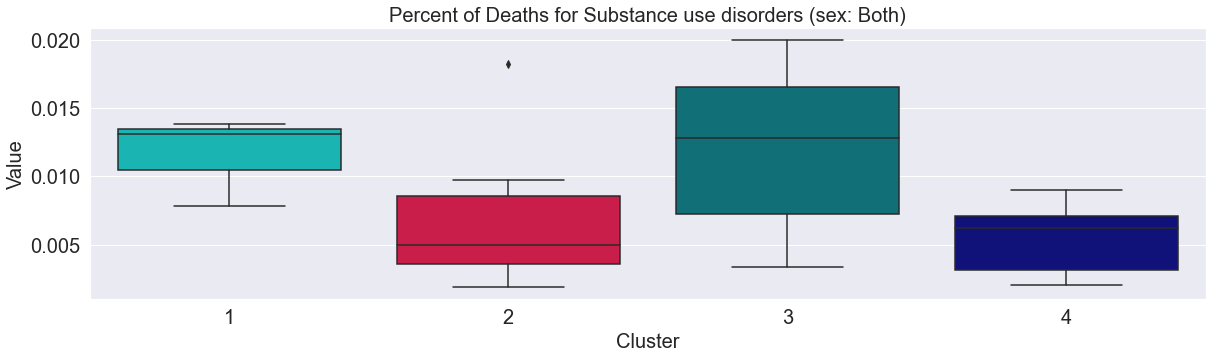

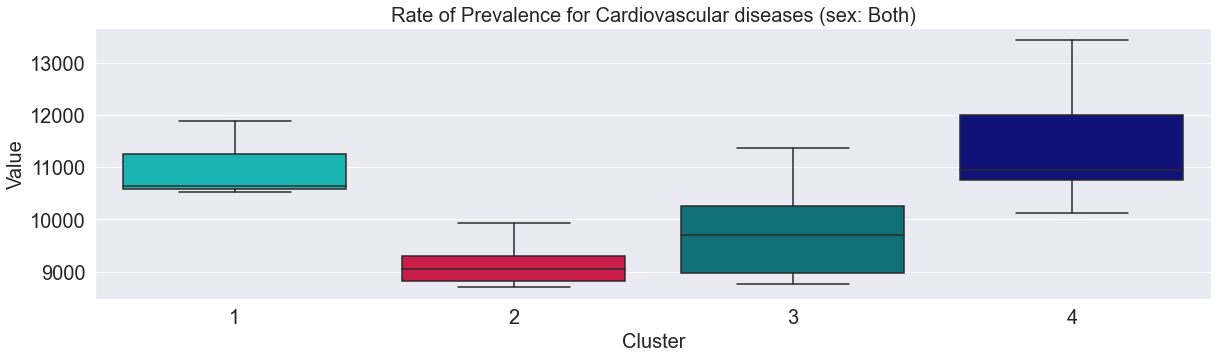

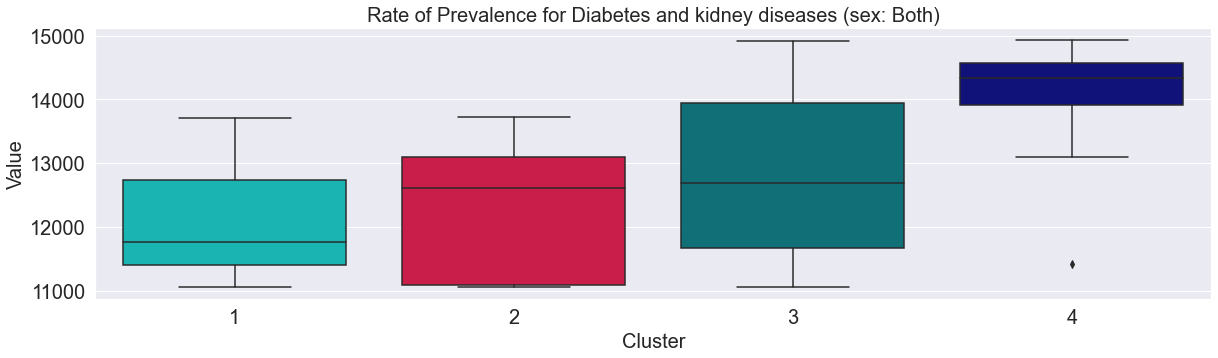

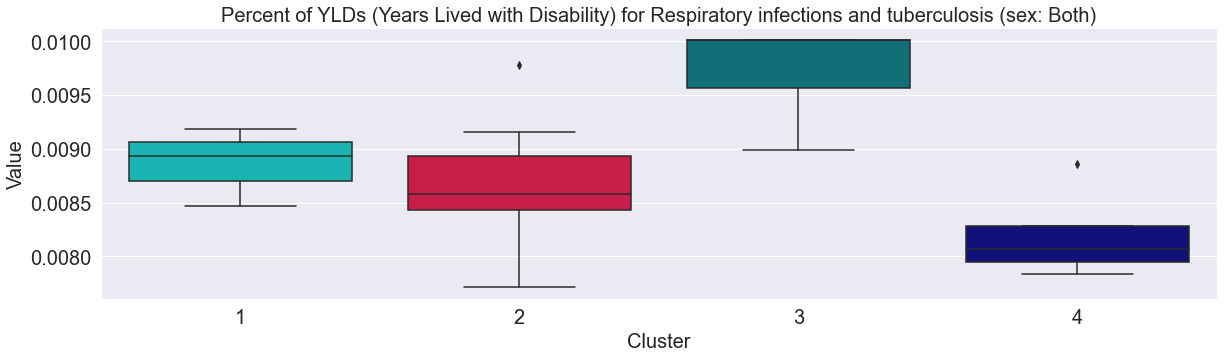

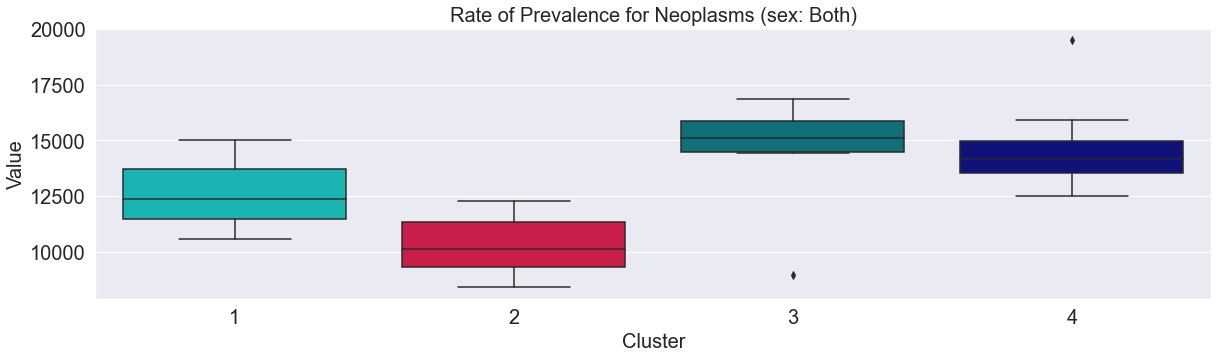

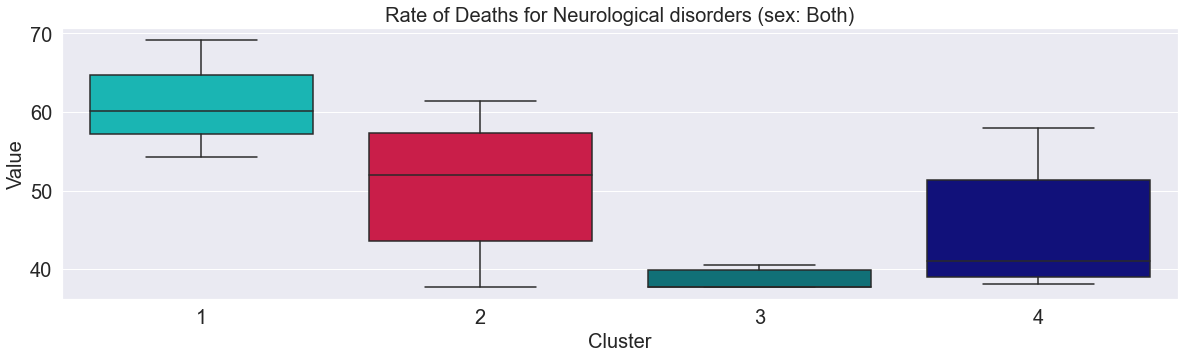

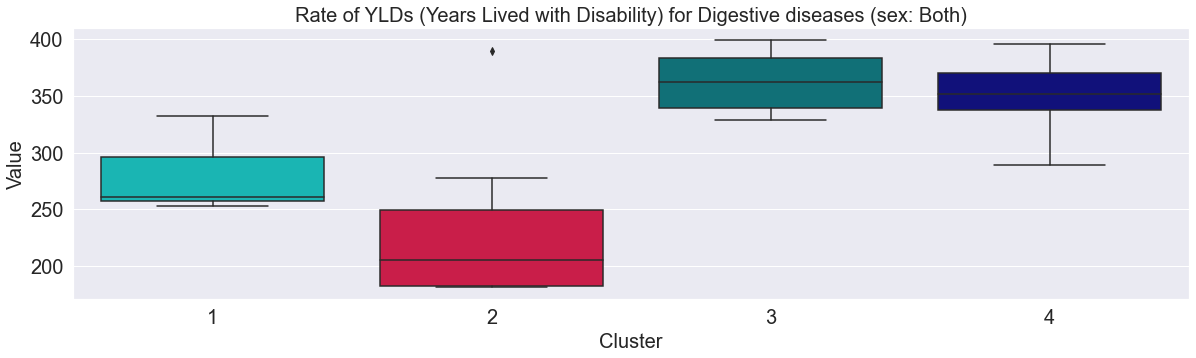

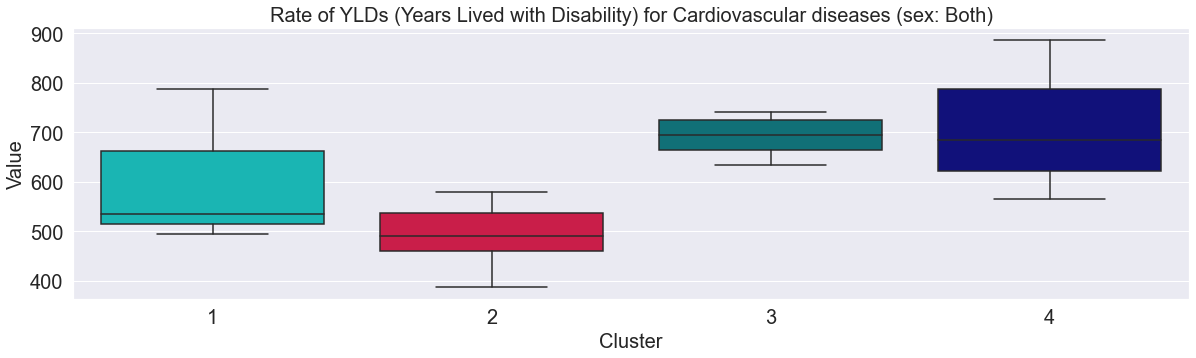

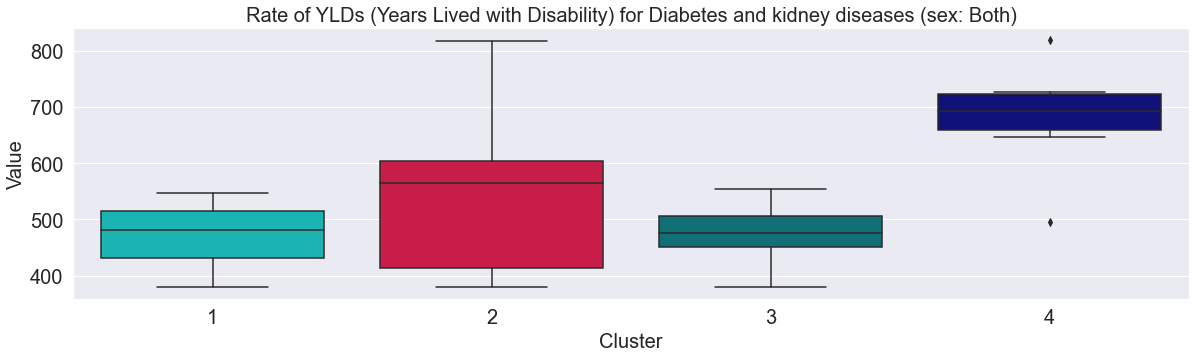

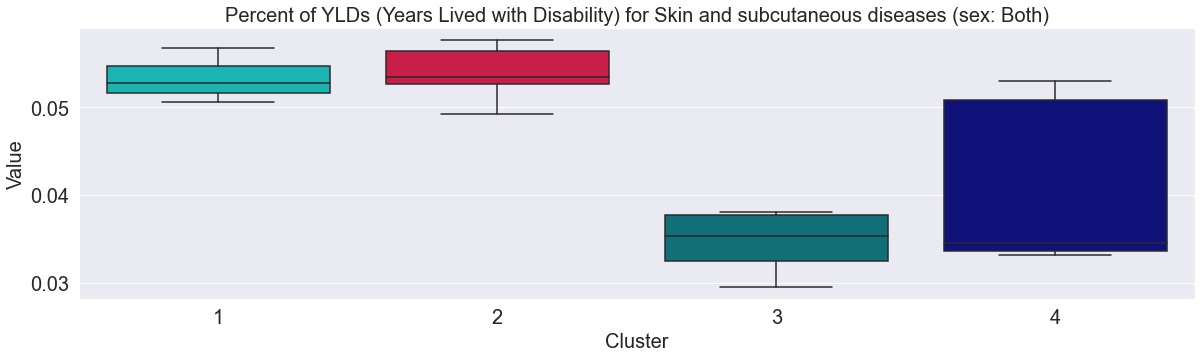

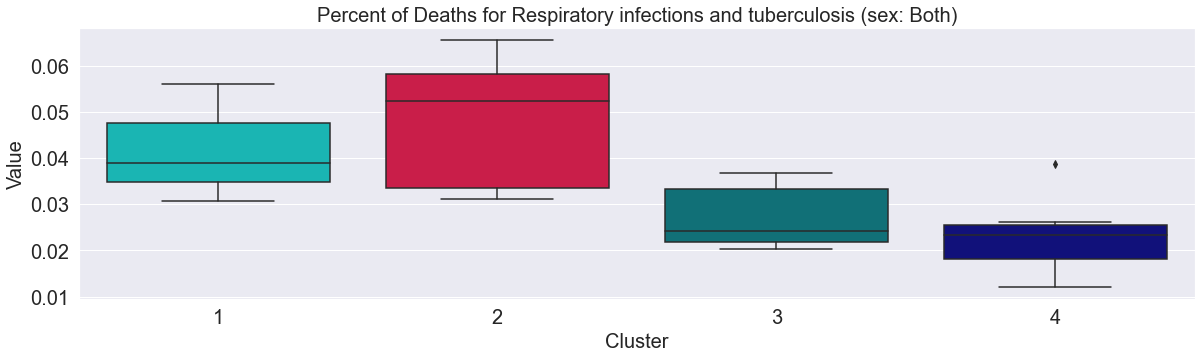

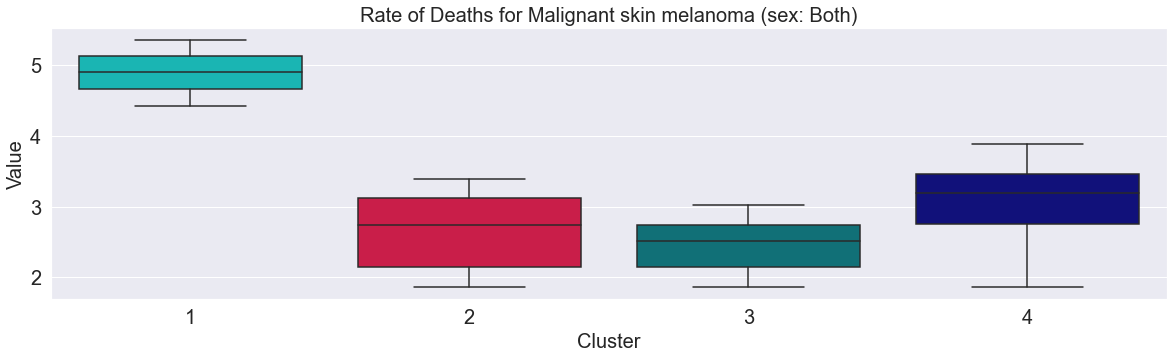

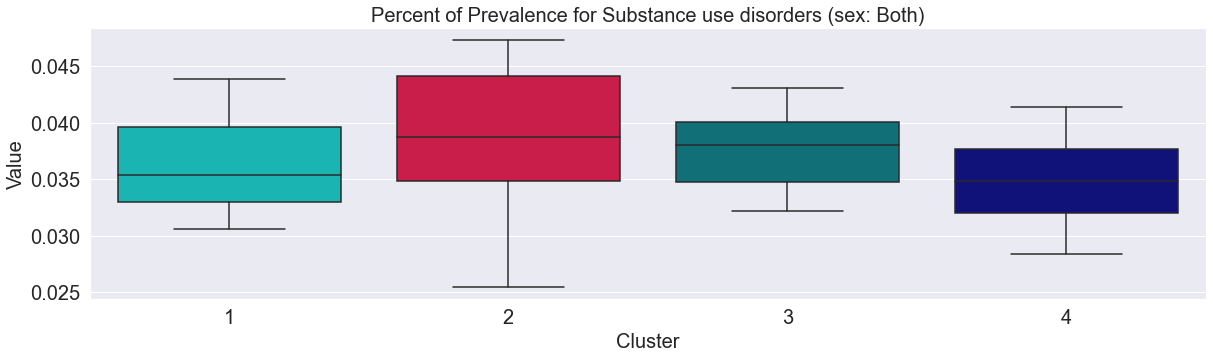

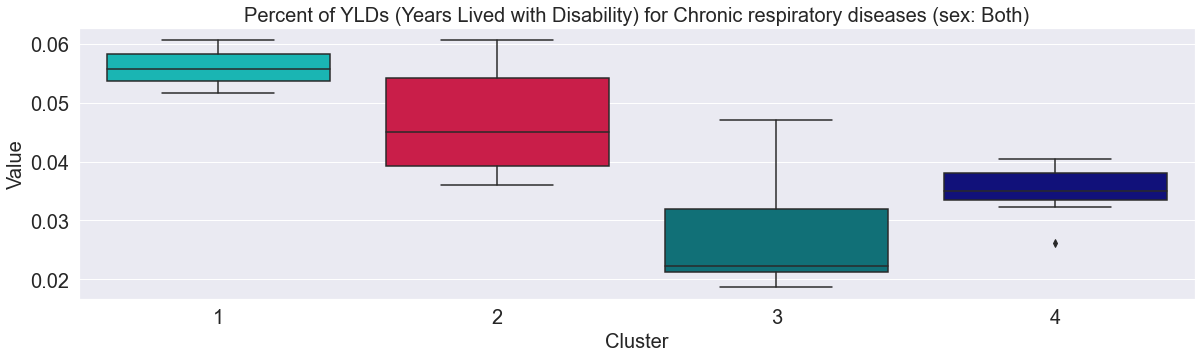

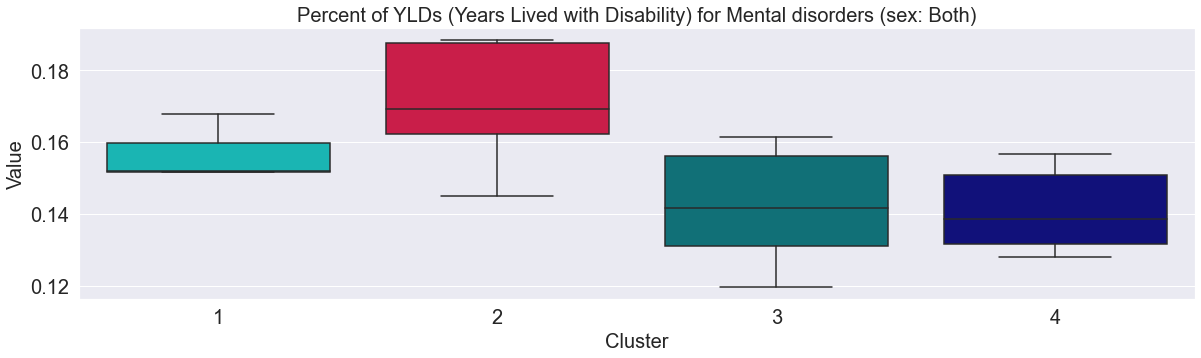

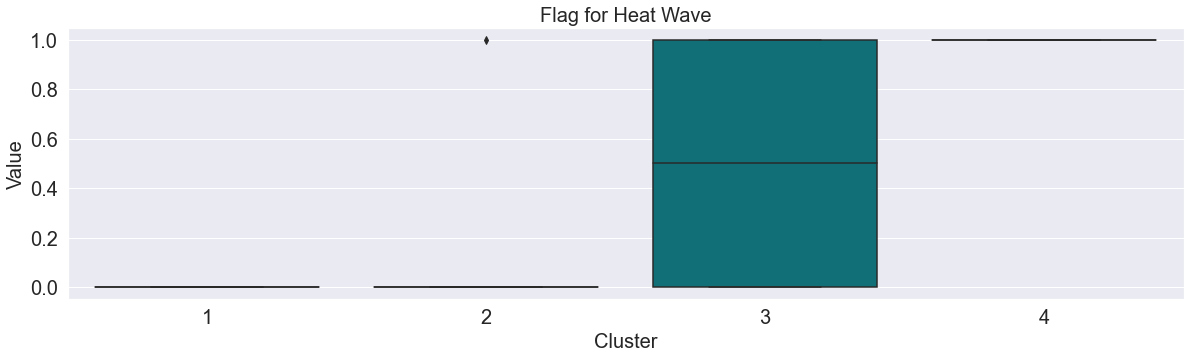

In [12]:
# Loop over variables to plot and save boxplot by cluster
for i in (['Rat-Dea-Bot-Sub_use_dis','Per-YLD-Bot-Res_inf_and_tub','Rat-Pre-Bot-Mal_ski_mel','Num-Dea-Bot-Men_dis','suicide_rate_est_WMEN'
          ,'suicide_rate_high_WMEN','Per-Dea-Bot-Sub_use_dis'] + vars_selected):
  # Plot boxplot
  fig, axes = plt.subplots(ncols=1, figsize = (20,5))
  b = sns.boxplot(x='cluster_KM', y=i, data=selected_data, palette = [colors[0],colors[1],colors[2],colors[5]])
  b.axes.set_title(list(features_diccionary[features_diccionary['variable'] == i]['description'])[0], fontsize=20)
  b.set_xlabel("Cluster",fontsize=20)
  b.set_ylabel("Value",fontsize=20)
  b.tick_params(labelsize=20)

  # Save plot
  plt.savefig(output_path + "\\" + 'plots_kmeans_charact' + "\\" + i +'_2000.png')
  plt.show()

## Classifying groups ahead

In [13]:
# Select variables to include
vars_selected = ['Rat-Pre-Bot-Car_dis', 'Rat-Pre-Bot-Dia_and_kid_dis', 'Per-YLD-Bot-Res_inf_and_tub', 'Rat-Pre-Bot-Neo'
              , 'Rat-Dea-Bot-Neu_dis', 'Rat-YLD-Bot-Dig_dis', 'Rat-YLD-Bot-Car_dis', 'Rat-YLD-Bot-Dia_and_kid_dis'
              , 'Per-YLD-Bot-Ski_and_sub_dis', 'Per-Dea-Bot-Res_inf_and_tub', 'Rat-Dea-Bot-Mal_ski_mel', 'Per-Pre-Bot-Sub_use_dis'
              , 'Per-YLD-Bot-Chr_res_dis', 'Per-YLD-Bot-Men_dis', 'Heat_wave']

years = list(filt_whole_df.Year.unique())

selected_data_append = []
for year in years:

  # Select data to use in clustering
  selected_data = filt_whole_df[filt_whole_df['Year'] == year]
  only_features = selected_data[vars_selected]

  # Transform data
  only_features = pd.DataFrame((only_features.values - q25) / (q75 - q25))
  only_features.columns = vars_selected

  # Classifying clusters
  cluster_pred = kmeans.fit_predict(only_features)

  # Concatenate data and cluster
  selected_data = pd.concat([selected_data.reset_index(drop=True),pd.DataFrame(cluster_pred).reset_index(drop=True)], axis=1)
  selected_data.columns = [*selected_data.columns[:-1], 'cluster_KM']

  selected_data_append.append(selected_data)

selected_data = pd.concat(selected_data_append, axis = 0).reset_index(drop=True)

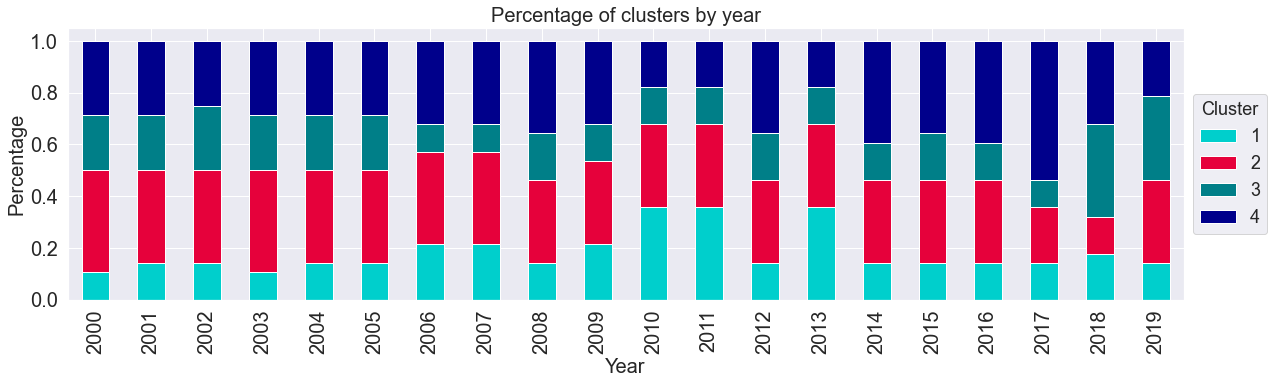

In [14]:
# Remap values of clusters to get numbers by heat wave percentage
convert_clust = {list(aux_cluster.cluster_KM)[i]: (list(aux_cluster.index)[i] + 1) for i in range(len(list(aux_cluster.cluster_KM)))}
selected_data.replace({"cluster_KM": convert_clust}, inplace = True)

# Get data grouped
cross_table = selected_data.groupby(['Year','cluster_KM']).count().reset_index()[['Year','cluster_KM','Country_code']]

# Reshape to get wide format
cross_table =  pd.pivot(cross_table, index=['Year'], columns = 'cluster_KM').droplevel(0, axis=1).reset_index().fillna(0)
cross_table.columns = ['Year','1','2','3','4']

# Calculate percentages
cross_table['1_pct'] = cross_table['1'] / (cross_table['1'] + cross_table['2'] + cross_table['3'] + cross_table['4'])
cross_table['2_pct'] = cross_table['2'] / (cross_table['1'] + cross_table['2'] + cross_table['3'] + cross_table['4'])
cross_table['3_pct'] = cross_table['3'] / (cross_table['1'] + cross_table['2'] + cross_table['3'] + cross_table['4'])
cross_table['4_pct'] = cross_table['4'] / (cross_table['1'] + cross_table['2'] + cross_table['3'] + cross_table['4'])
cross_table = cross_table.drop(['1','2','3','4'], axis=1)

# Plot
fig, axes = plt.subplots(ncols=1, figsize = (20,5))
cross_table.plot(x = 'Year', kind = 'bar', stacked = True, title = 'Percentage of clusters by year', ax =axes
                , color = [colors[0],colors[1],colors[2],colors[5]], fontsize = 20)

axes.title.set_size(20)
axes.legend(['1', '2','3','4'], fontsize = 18, loc='center left', bbox_to_anchor=(1.0, 0.5), title = "Cluster", title_fontsize=18)
axes.set_xlabel("Year", size = 20)
axes.set_ylabel("Percentage", size = 20)
plt.savefig(output_path + "\\" + r"plots_kmeans_charact\distribution_cluster_vs_time.png")

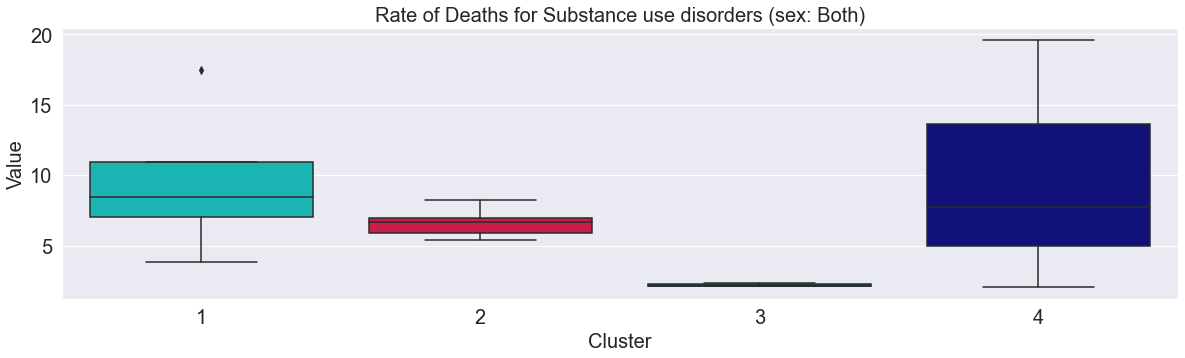

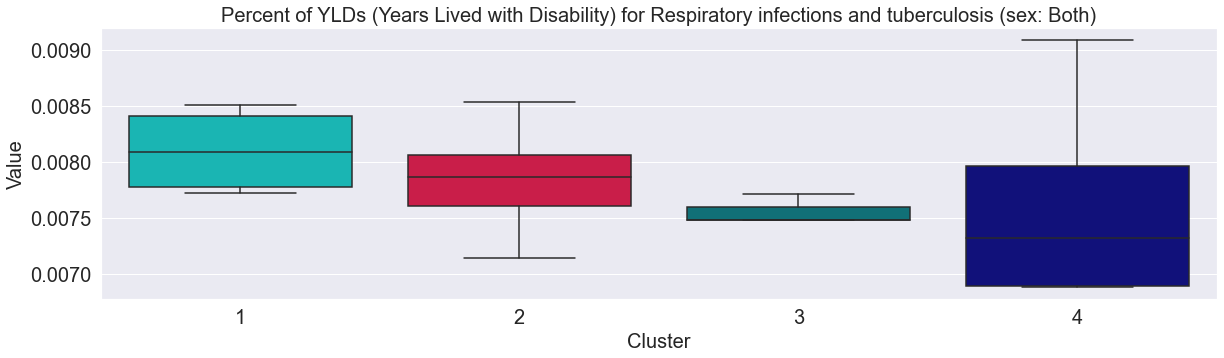

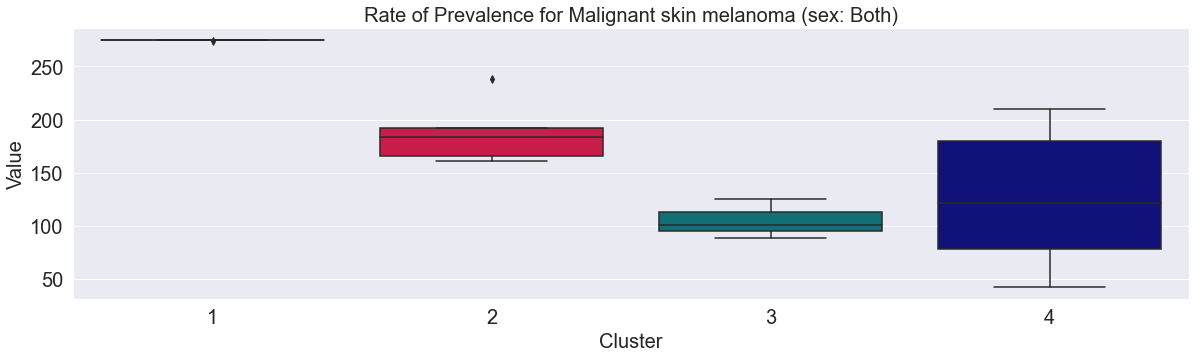

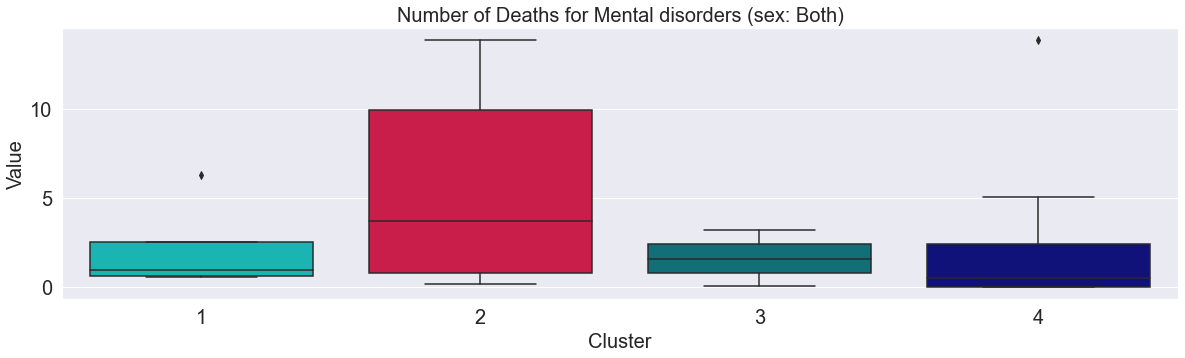

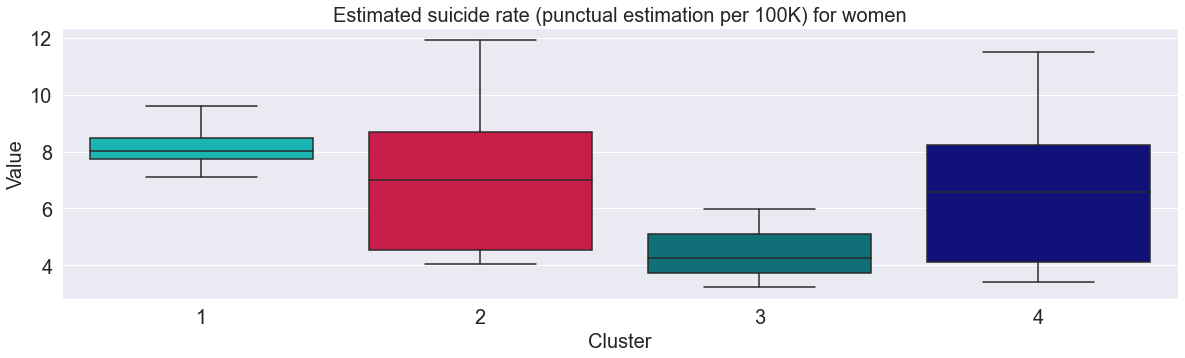

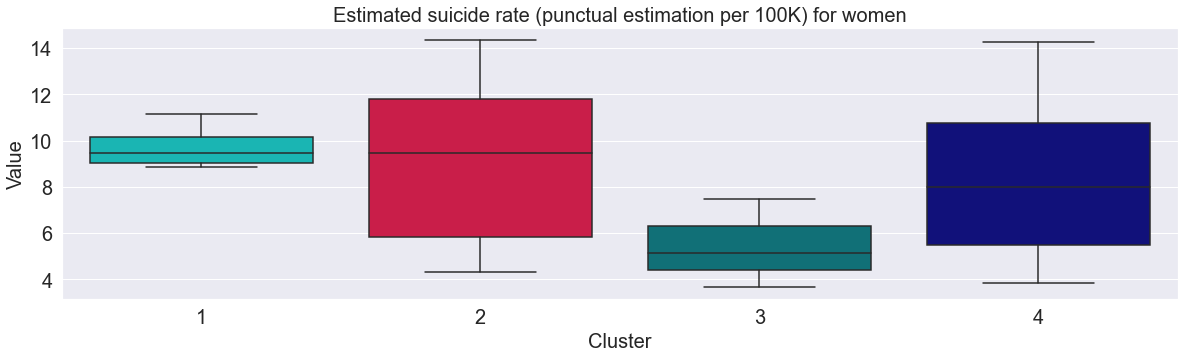

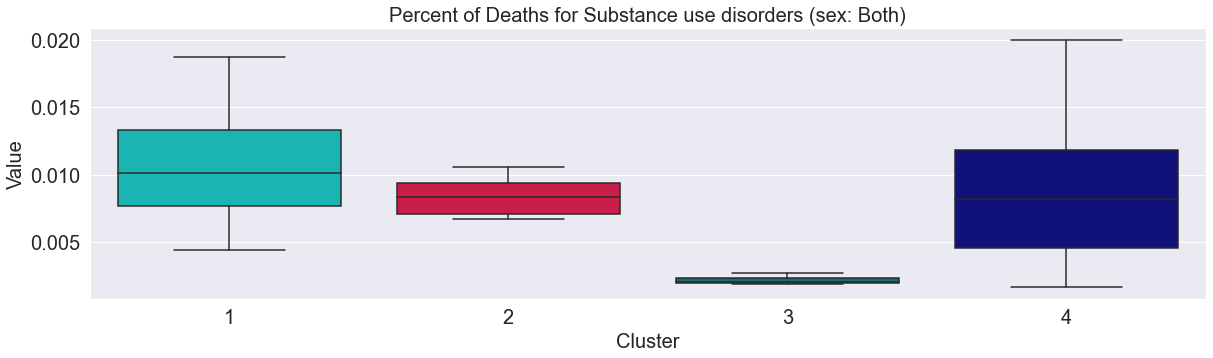

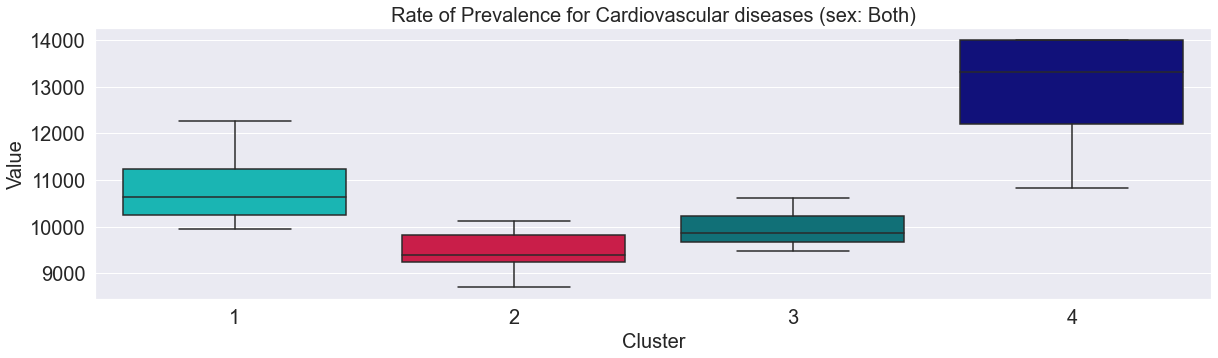

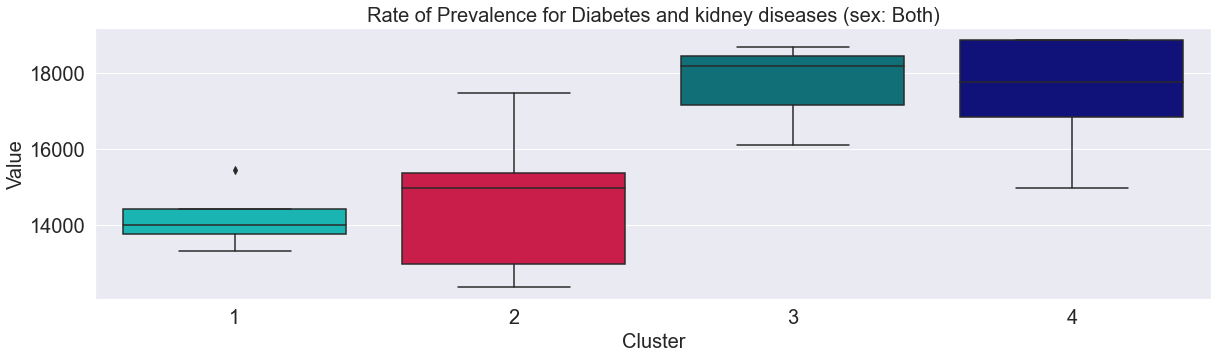

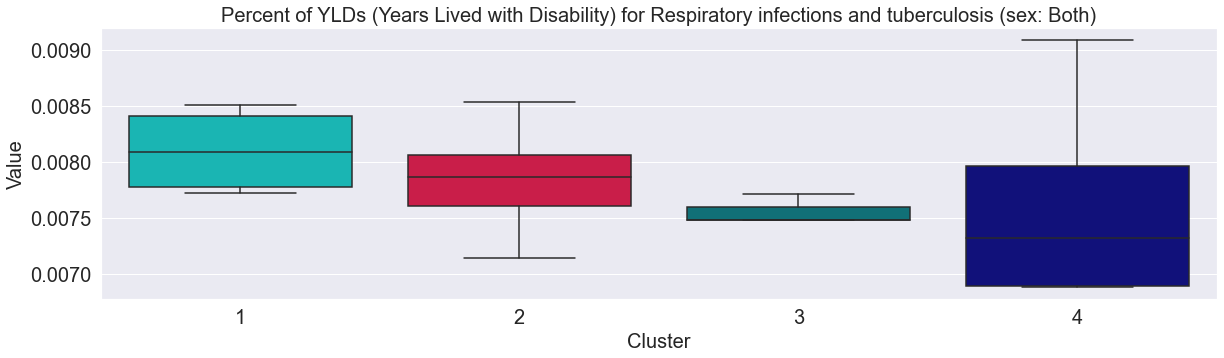

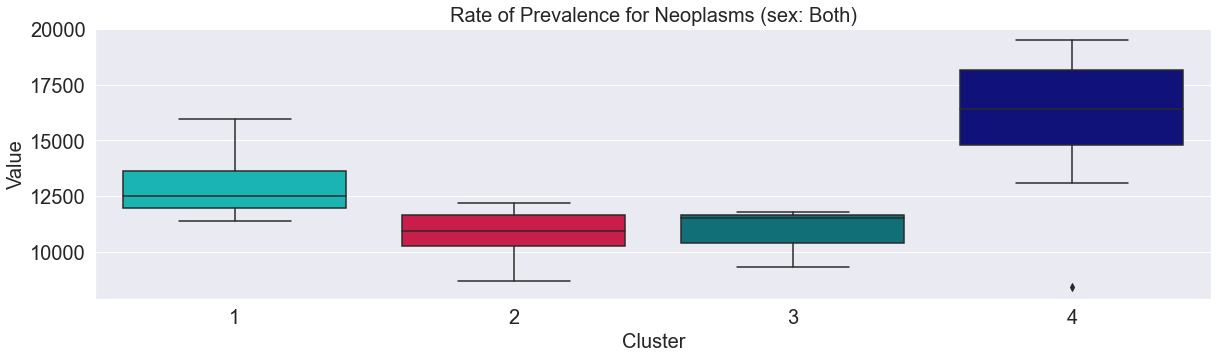

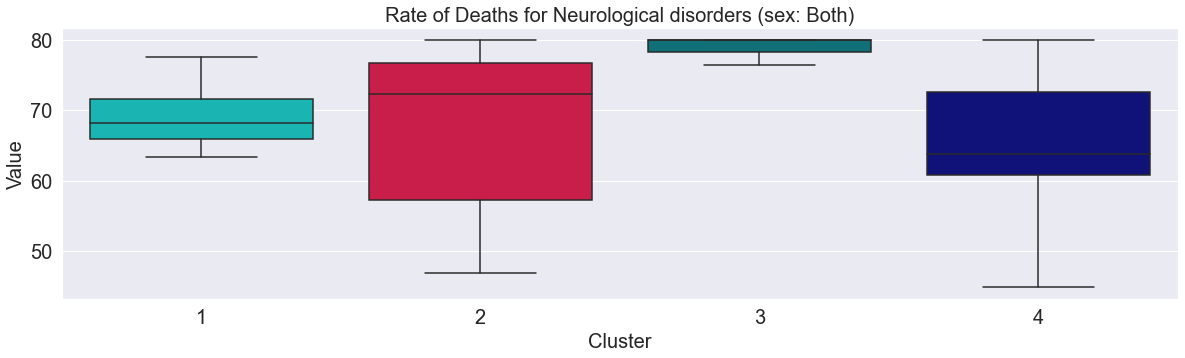

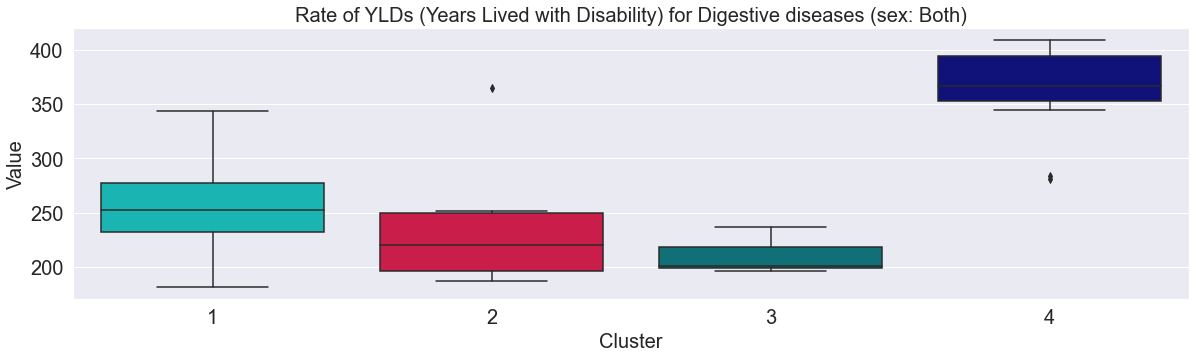

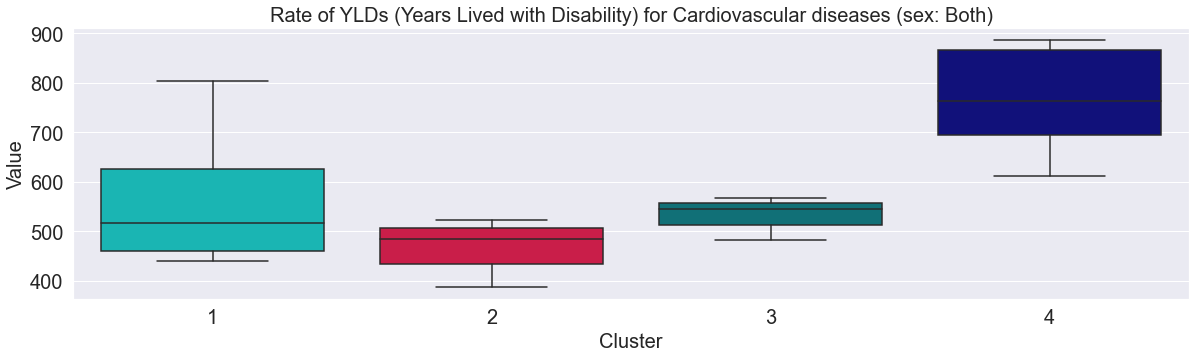

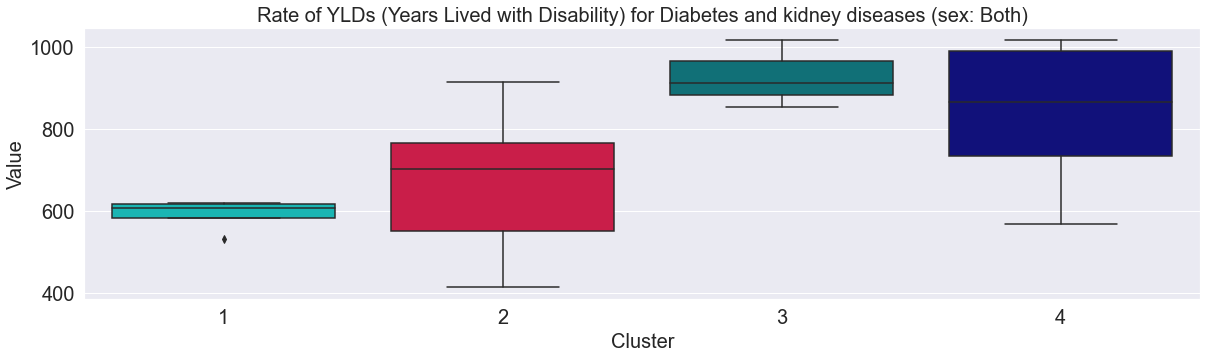

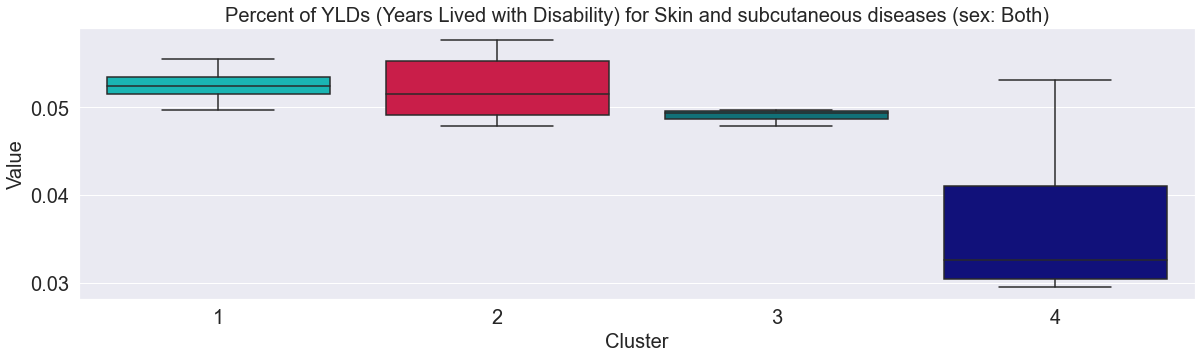

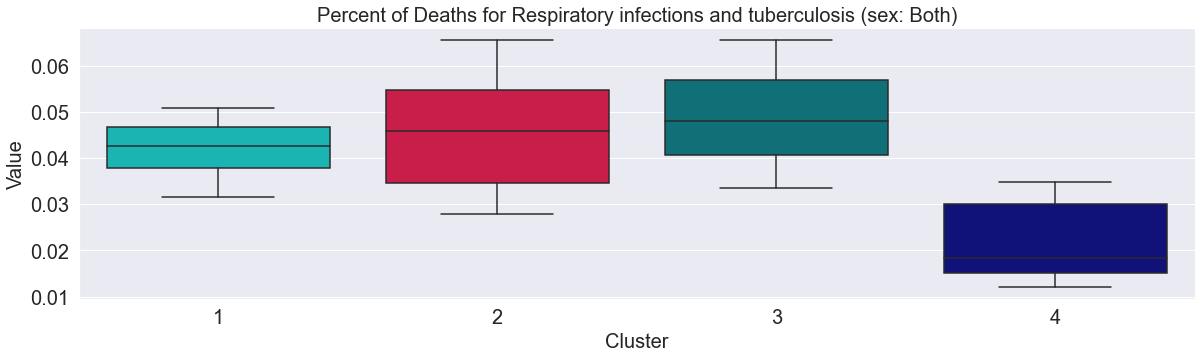

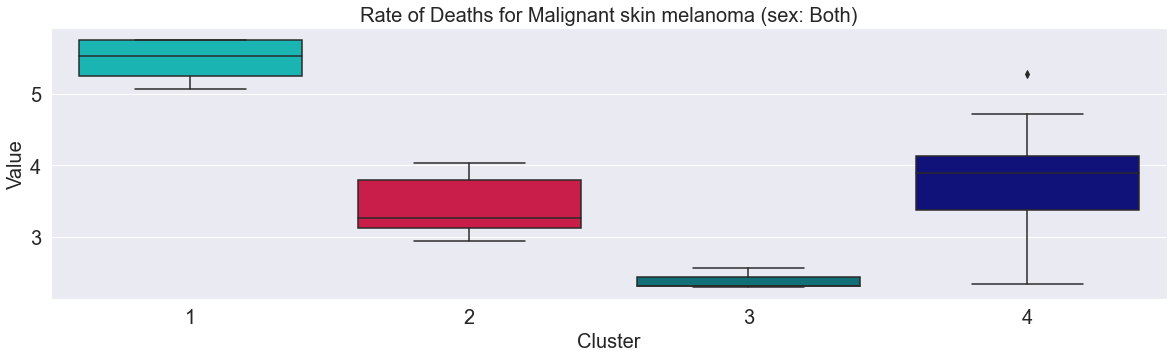

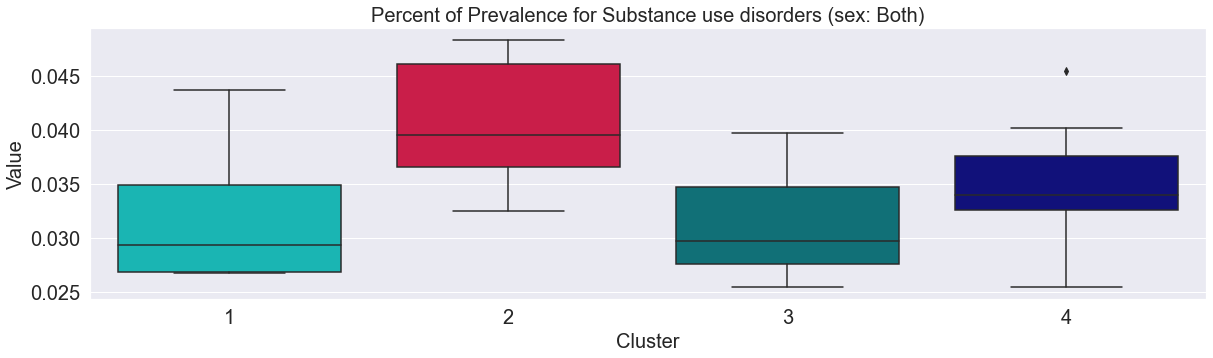

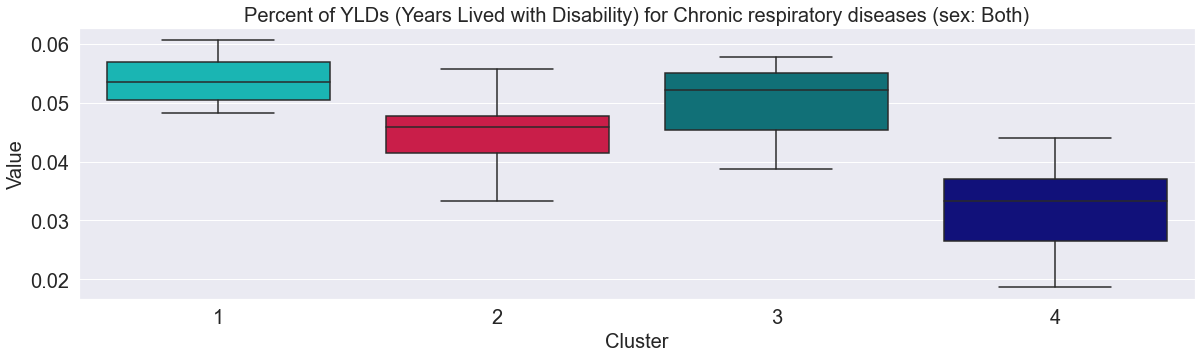

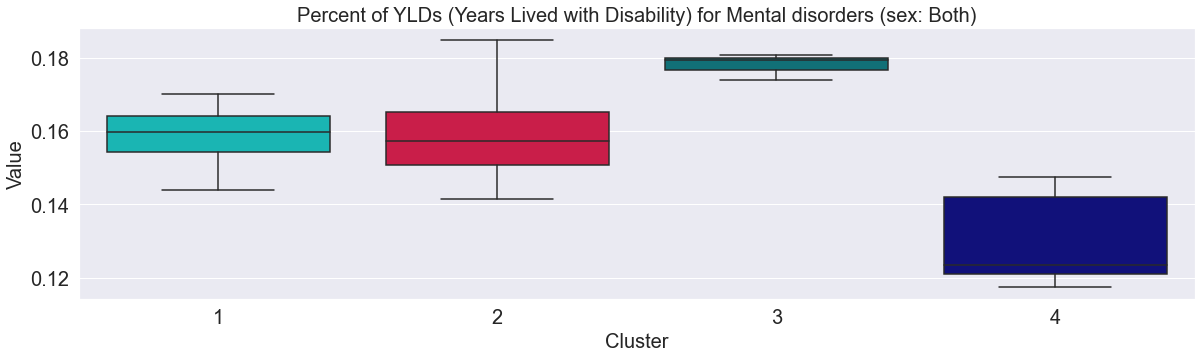

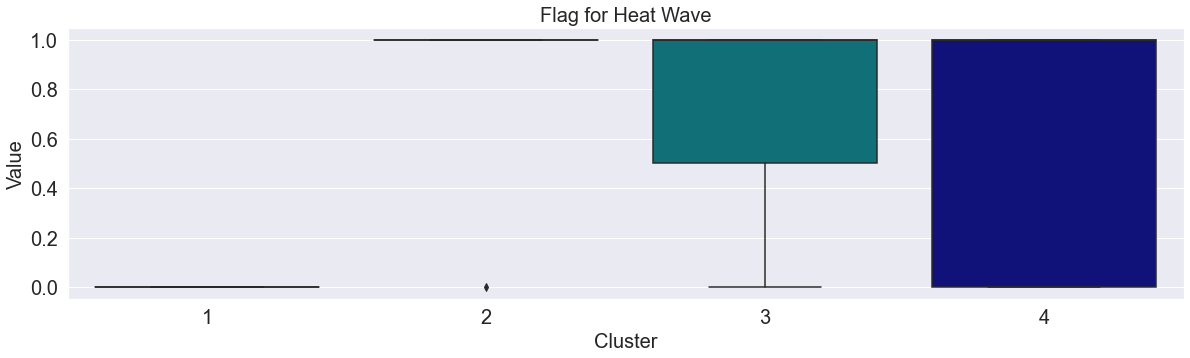

In [15]:
# Loop over variables to plot and save boxplot by cluster
for i in (['Rat-Dea-Bot-Sub_use_dis','Per-YLD-Bot-Res_inf_and_tub','Rat-Pre-Bot-Mal_ski_mel','Num-Dea-Bot-Men_dis','suicide_rate_est_WMEN'
          ,'suicide_rate_high_WMEN','Per-Dea-Bot-Sub_use_dis'] + vars_selected):
  # Plot boxplot
  fig, axes = plt.subplots(ncols=1, figsize = (20,5))
  b = sns.boxplot(x='cluster_KM', y=i, data=selected_data[selected_data['Year'] == 2017], palette = [colors[0],colors[1],colors[2],colors[5]])
  b.axes.set_title(list(features_diccionary[features_diccionary['variable'] == i]['description'])[0], fontsize=20)
  b.set_xlabel("Cluster",fontsize=20)
  b.set_ylabel("Value",fontsize=20)
  b.tick_params(labelsize=20)

  # Save plot
  plt.savefig(output_path + "\\" + 'plots_kmeans_charact' + "\\" + i +'_2019_pred.png')
  plt.show()

In [16]:
before_2000 = selected_data[selected_data['Year'] == 2000].reset_index(drop=True)
before_2000.rename(columns={'cluster_KM':'cluster_KM_2000'},inplace=True)

after = selected_data[selected_data['Year'] == 2019].reset_index(drop=True)
after.rename(columns={'cluster_KM':'cluster_KM_2019'},inplace=True)

cluster_KM_2019  1  2  3  4
cluster_KM_2000            
1                3  0  0  0
2                1  9  1  0
3                0  0  1  5
4                0  0  7  1
--------------------------------------------------
--------------------------------------------------


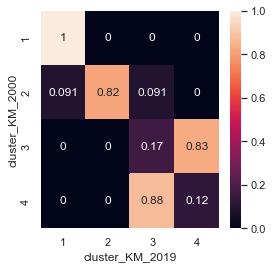

In [17]:
print(pd.crosstab(before_2000.cluster_KM_2000, after.cluster_KM_2019))
print("--------------------------------------------------")
print("--------------------------------------------------")
plt.subplots(figsize=(4, 4))
sns.heatmap(pd.crosstab(before_2000.cluster_KM_2000, after.cluster_KM_2019).apply(lambda r: r/r.sum(), axis=1), annot=True)
plt.show()

In [18]:
comp_clusters = pd.merge(before_2000[['Country', 'cluster_KM_2000']],
                         after[['Country', 'cluster_KM_2019']],
                         on='Country', how='inner')

comp_clusters.sort_values(by=['cluster_KM_2000','cluster_KM_2019'], axis=0, ascending=True, inplace=True)
comp_clusters.reset_index(drop=True, inplace=True)
comp_clusters

,Country,cluster_KM_2000,cluster_KM_2019
0,Denmark,1,1
1,Norway,1,1
2,Sweden,1,1
3,Netherlands,2,1
4,Belgium,2,2
5,Switzerland,2,2
6,Spain,2,2
7,France,2,2
8,United Kingdom,2,2
9,Greece,2,2


## Clustering with 2019

##### Hierarchical

In [19]:
# Select variables to include
vars_selected = ['Rat-Pre-Bot-Car_dis', 'Rat-Pre-Bot-Dia_and_kid_dis', 'Per-YLD-Bot-Res_inf_and_tub', 'Rat-Pre-Bot-Neo'
              , 'Rat-Dea-Bot-Neu_dis', 'Rat-YLD-Bot-Dig_dis', 'Rat-YLD-Bot-Car_dis', 'Rat-YLD-Bot-Dia_and_kid_dis'
              , 'Per-YLD-Bot-Ski_and_sub_dis', 'Per-Dea-Bot-Res_inf_and_tub', 'Rat-Dea-Bot-Mal_ski_mel', 'Per-Pre-Bot-Sub_use_dis'
              , 'Per-YLD-Bot-Chr_res_dis', 'Per-YLD-Bot-Men_dis', 'Heat_wave']

# Select data to use in clustering
selected_data = filt_whole_df[filt_whole_df['Year'] == 2019]
only_features = selected_data[vars_selected]

# Quantiles for Robust normalization
q25 = only_features.quantile(0.25).values
q50 = only_features.quantile(0.50).values
q75 = only_features.quantile(0.75).values

# Transform data
only_features = pd.DataFrame((only_features.values - q50) / (q75 - q25))
only_features.columns = vars_selected

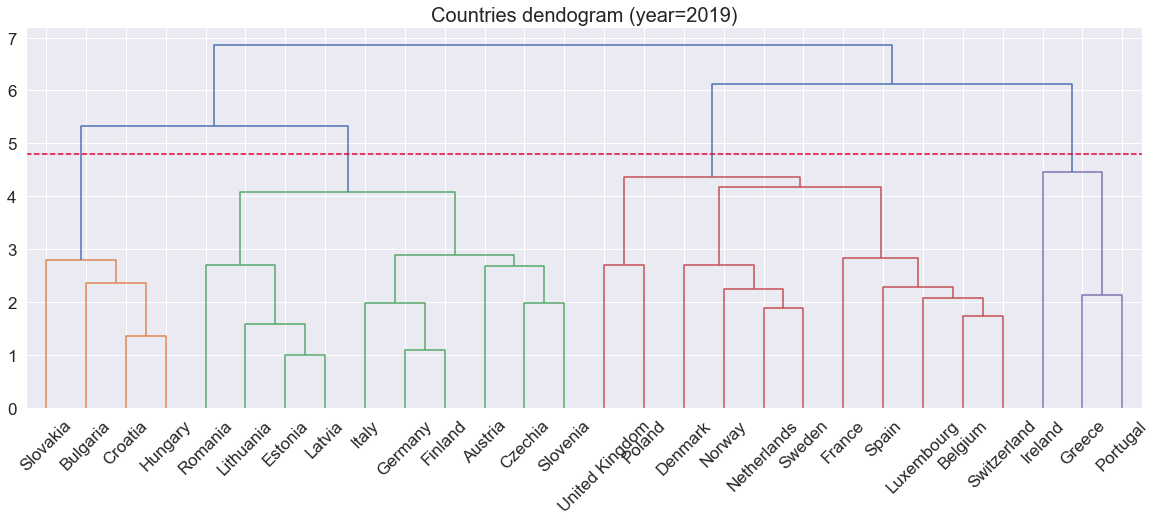

In [20]:
# Fit hierarchical clusternig
clusters = shc.linkage(only_features, method='complete',  metric="euclidean")

# Plot dendogram
plt.figure(figsize=(20, 7))
plt.title("Countries dendogram (year=2019)",fontsize=20)
shc.dendrogram(Z=clusters, labels = list(selected_data['Country']))
plt.tick_params(labelsize=17)
plt.axhline(y = 4.8, color = colors[1], linestyle = '--')
plt.show()

In [21]:
# Run clustering to get predictions
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'complete')

# Classifying clusters
cluster_pred = hc.fit_predict(only_features)

# Concatenate data and cluster
selected_data = pd.concat([selected_data.reset_index(drop=True),pd.DataFrame(cluster_pred).reset_index(drop=True)], axis=1)
selected_data.columns = [*selected_data.columns[:-1], 'cluster_HC']

# Calculate silhouette_score to make comparissons
score_HC = silhouette_score(only_features, selected_data.cluster_HC, metric='euclidean')
print("\nSilhouette score:", score_HC)

# Get variable by cluster to characterize
charact_clus_HC = selected_data[['cluster_HC'] + vars_selected].groupby('cluster_HC').mean().reset_index()
charact_clus_HC


Silhouette score: 0.26913534609869555


,cluster_HC,Rat-Pre-Bot-Car_dis,Rat-Pre-Bot-Dia_and_kid_dis,Per-YLD-Bot-Res_inf_and_tub,Rat-Pre-Bot-Neo,Rat-Dea-Bot-Neu_dis,Rat-YLD-Bot-Dig_dis,Rat-YLD-Bot-Car_dis,Rat-YLD-Bot-Dia_and_kid_dis,Per-YLD-Bot-Ski_and_sub_dis,Per-Dea-Bot-Res_inf_and_tub,Rat-Dea-Bot-Mal_ski_mel,Per-Pre-Bot-Sub_use_dis,Per-YLD-Bot-Chr_res_dis,Per-YLD-Bot-Men_dis,Heat_wave
0,0,9937.194551,16940.237739,0.007693,10623.854852,69.684390,208.563313,510.328088,830.191462,0.050397,0.055632,2.736711,0.036976,0.051048,0.177955,0.0
1,1,13246.887153,17869.292849,0.007589,16308.534320,72.450888,351.311720,757.874300,845.887933,0.038282,0.021702,3.851165,0.033825,0.030468,0.135789,1.0
2,2,10325.314519,15575.971228,0.007759,11608.393416,71.376709,259.866308,549.089722,747.748148,0.049741,0.041494,4.206234,0.036280,0.047226,0.153291,1.0
3,3,13081.542222,18205.648591,0.007018,16508.530945,60.501064,383.411175,834.196713,964.403205,0.031271,0.018938,3.753695,0.032021,0.032954,0.119494,0.0


##### K-means

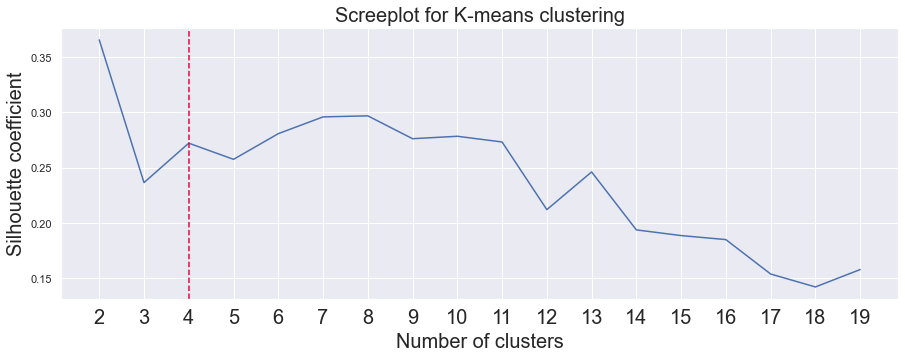

In [22]:
# Define parameters for k-means
kmeans_kwargs = { "init": "k-means++", "n_init": 10, "max_iter": 500, "random_state": random_state}

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Loop to get best number of groups
for k in range(2, 20):
    # Define K-means
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)

    # Fit K-means
    kmeans.fit(only_features)

    # Calculate Silhouette score
    score = silhouette_score(only_features, kmeans.labels_)
    silhouette_coefficients.append(score)

# Plot Silhouette score to get best number of clusters
plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), silhouette_coefficients)
plt.title("Screeplot for K-means clustering",fontsize=20)
plt.xticks(range(2, 20), fontsize = 20)
plt.xlabel("Number of clusters", fontsize = 20)
plt.ylabel("Silhouette coefficient", fontsize = 20)
plt.axvline(x = 4, color = colors[1], linestyle = '--')
plt.show()

In [23]:
# Fit k-Means
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)

# Predict clusters
cluster_pred = kmeans.fit_predict(only_features)

# # Concatenate data and cluster
selected_data = pd.concat([selected_data.reset_index(drop=True),pd.DataFrame(cluster_pred).reset_index(drop=True)], axis=1)
selected_data.columns = [*selected_data.columns[:-1], 'cluster_KM']

# Remap values of clusters to get numbers by heat wave percentage
aux_cluster = selected_data[['cluster_KM', 'Heat_wave']].groupby('cluster_KM').mean().reset_index().sort_values(by = 'Heat_wave').reset_index(drop=True)
convert_clust = {list(aux_cluster.cluster_KM)[i]: (list(aux_cluster.index)[i] + 1) for i in range(len(list(aux_cluster.cluster_KM)))}
selected_data.replace({"cluster_KM": convert_clust}, inplace = True)

# Calculate silhouette_score to make comparissons
score_KM = silhouette_score(only_features, selected_data.cluster_KM, metric='euclidean')
print("\nSilhouette score:", score_KM)

# Get variable by cluster to characterize
charact_clus_KM = selected_data[['cluster_KM'] + vars_selected].groupby('cluster_KM').mean().reset_index()
aux_cant = selected_data.cluster_KM.value_counts().reset_index().sort_values(by='index').reset_index(drop=True)
aux_cant.columns = ['cluster_KM','num_countries']

charact_clus_KM = pd.concat([charact_clus_KM, aux_cant['num_countries']], axis = 1)
charact_clus_KM


Silhouette score: 0.27220085171380937


,cluster_KM,Rat-Pre-Bot-Car_dis,Rat-Pre-Bot-Dia_and_kid_dis,Per-YLD-Bot-Res_inf_and_tub,Rat-Pre-Bot-Neo,Rat-Dea-Bot-Neu_dis,Rat-YLD-Bot-Dig_dis,Rat-YLD-Bot-Car_dis,Rat-YLD-Bot-Dia_and_kid_dis,Per-YLD-Bot-Ski_and_sub_dis,Per-Dea-Bot-Res_inf_and_tub,Rat-Dea-Bot-Mal_ski_mel,Per-Pre-Bot-Sub_use_dis,Per-YLD-Bot-Chr_res_dis,Per-YLD-Bot-Men_dis,Heat_wave,num_countries
0,1,9937.194551,16940.237739,0.007693,10623.854852,69.684390,208.563313,510.328088,830.191462,0.050397,0.055632,2.736711,0.036976,0.051048,0.177955,0.0,3
1,2,13081.542222,18205.648591,0.007018,16508.530945,60.501064,383.411175,834.196713,964.403205,0.031271,0.018938,3.753695,0.032021,0.032954,0.119494,0.0,4
2,3,10549.133881,15999.589862,0.007646,11893.774047,72.702006,262.145930,563.157189,783.604804,0.049661,0.038301,4.177101,0.035767,0.046303,0.151390,1.0,13
3,4,13613.573848,17754.242974,0.007731,17019.826022,70.565826,370.468686,787.210810,812.155813,0.035547,0.021942,3.809740,0.034045,0.027779,0.134503,1.0,8


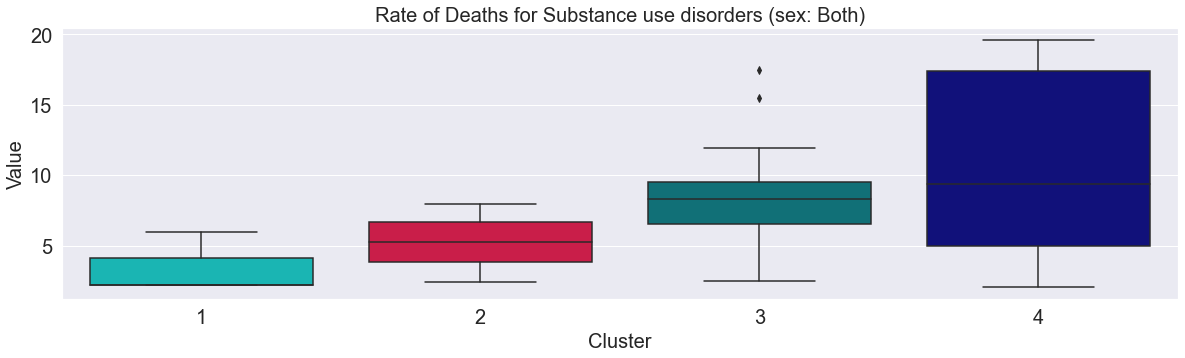

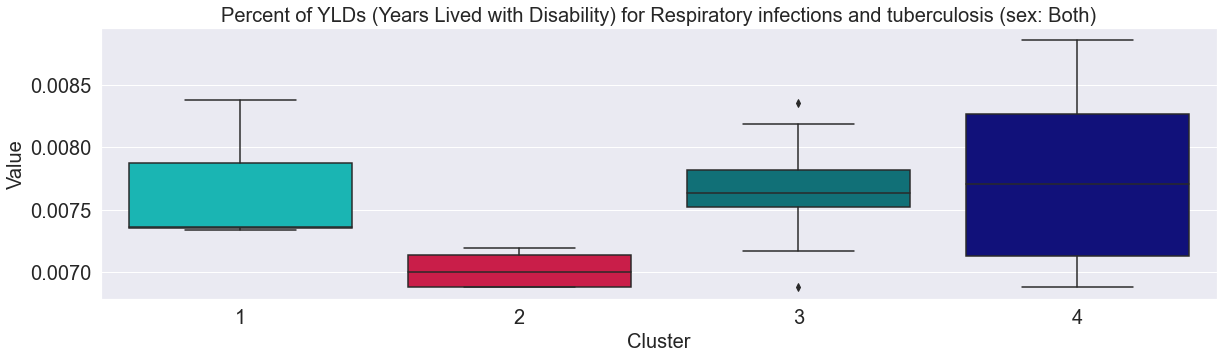

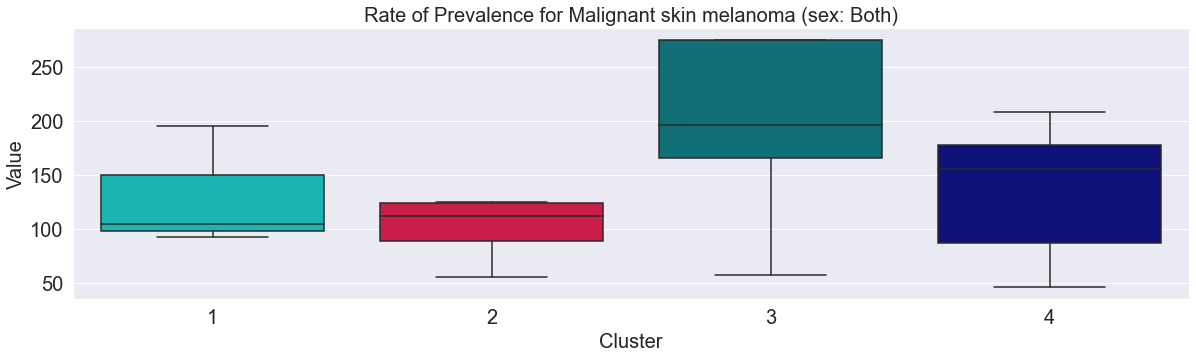

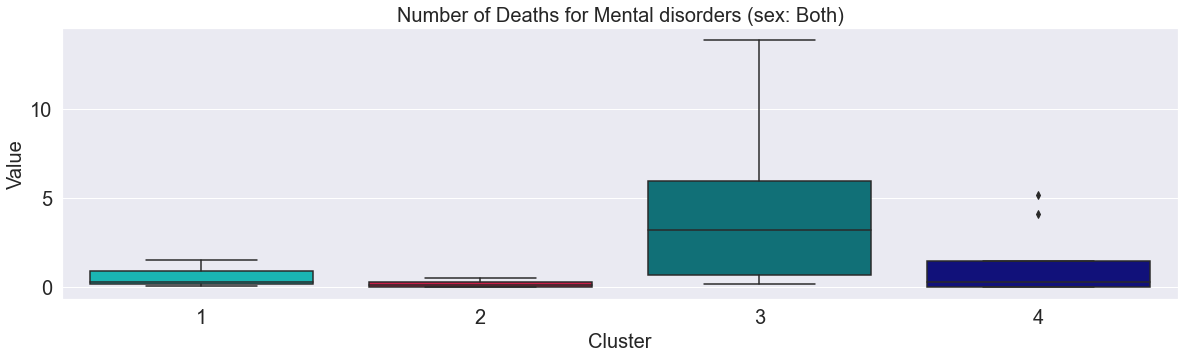

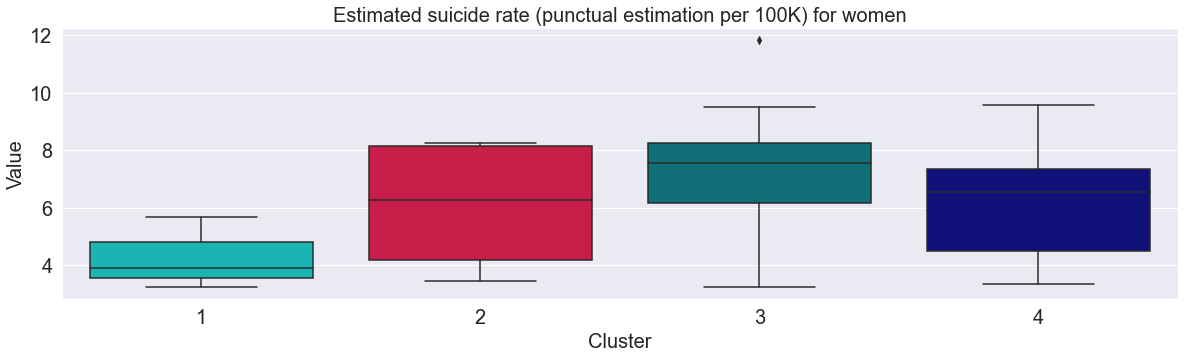

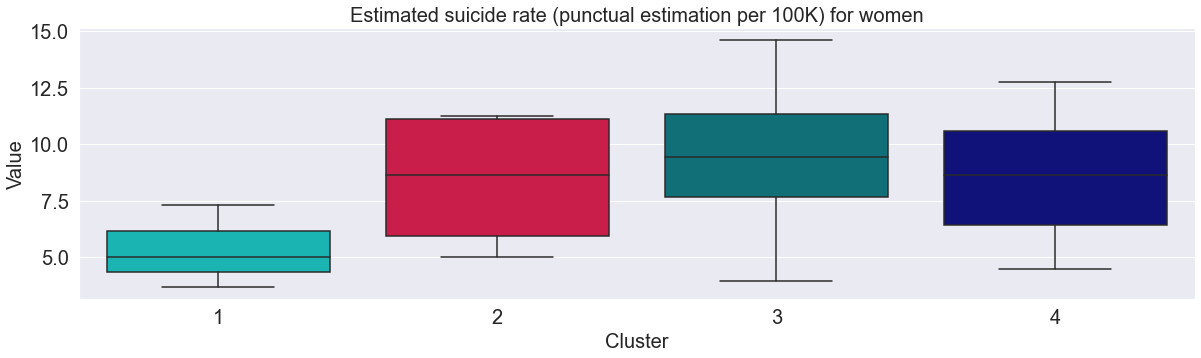

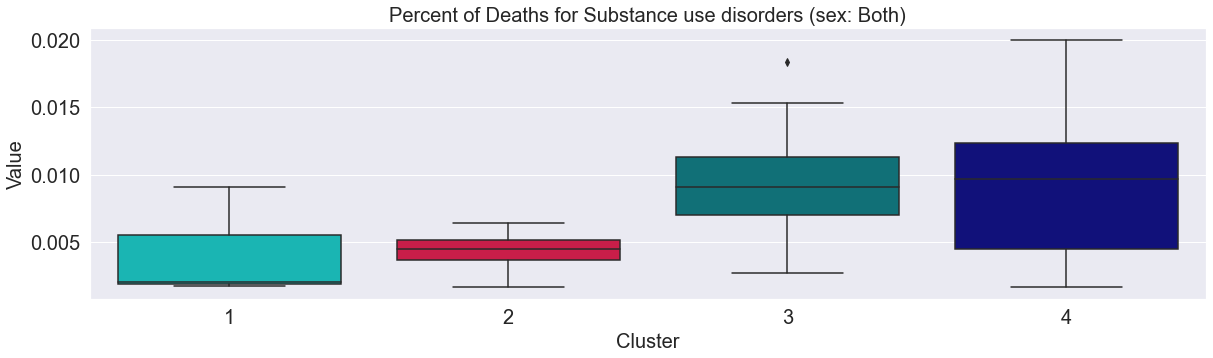

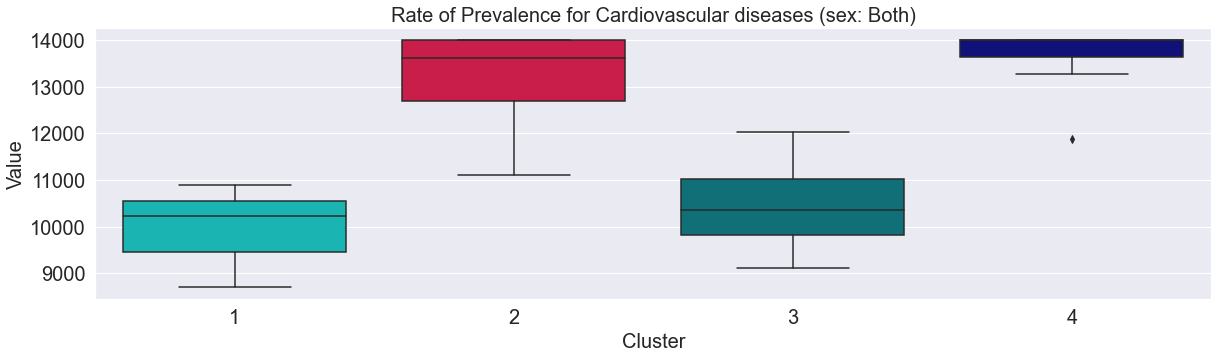

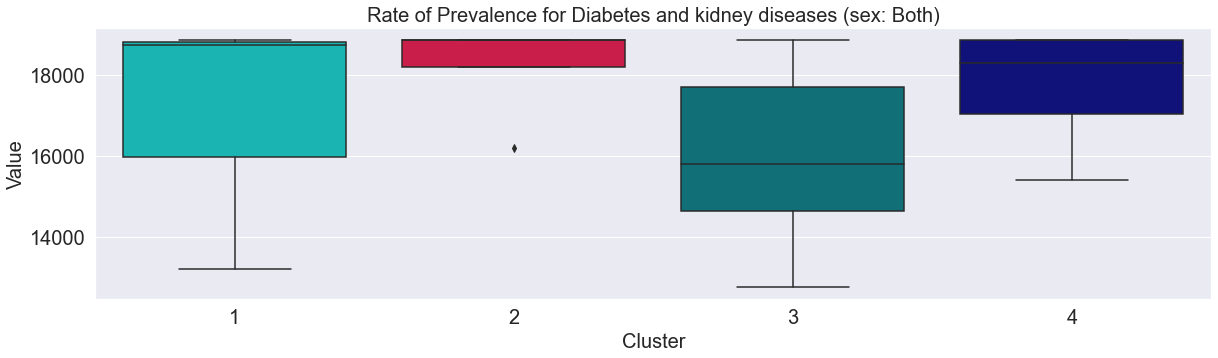

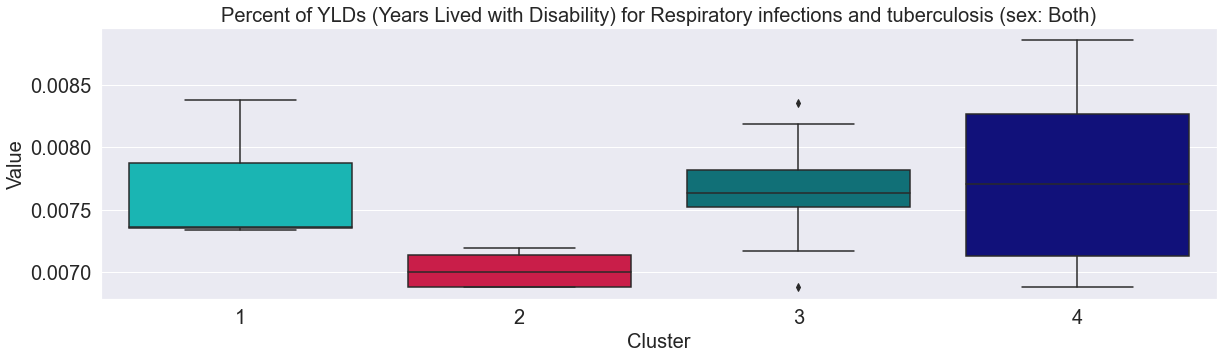

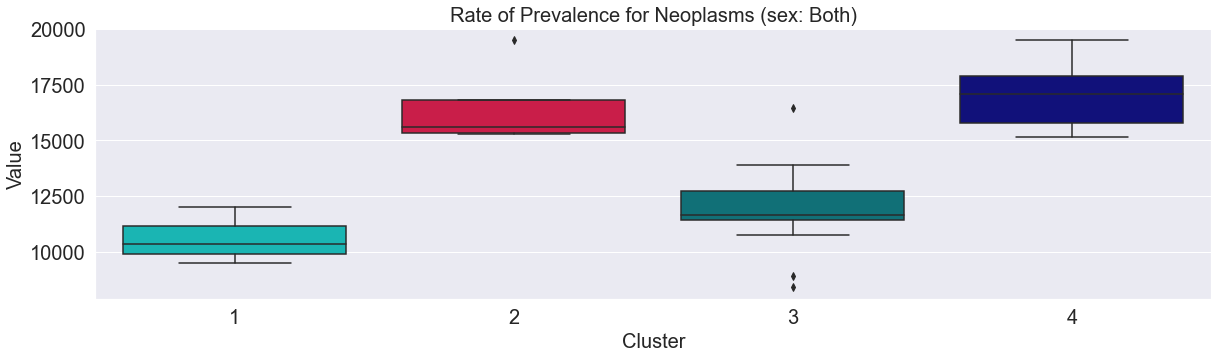

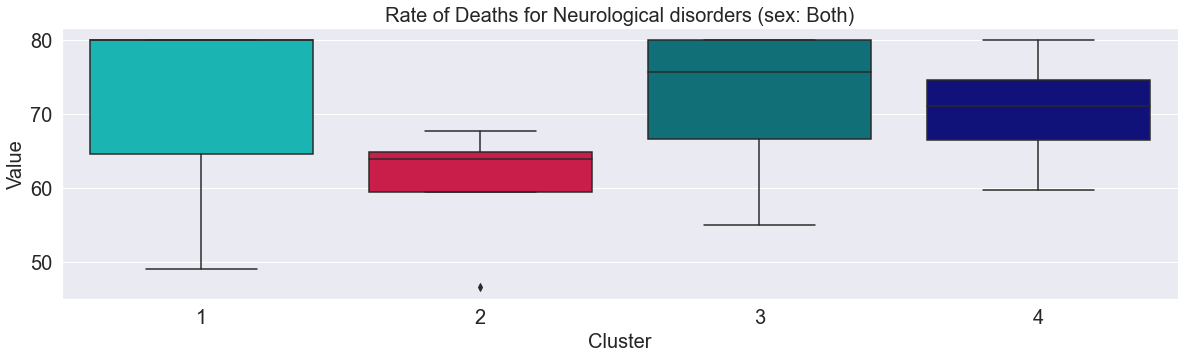

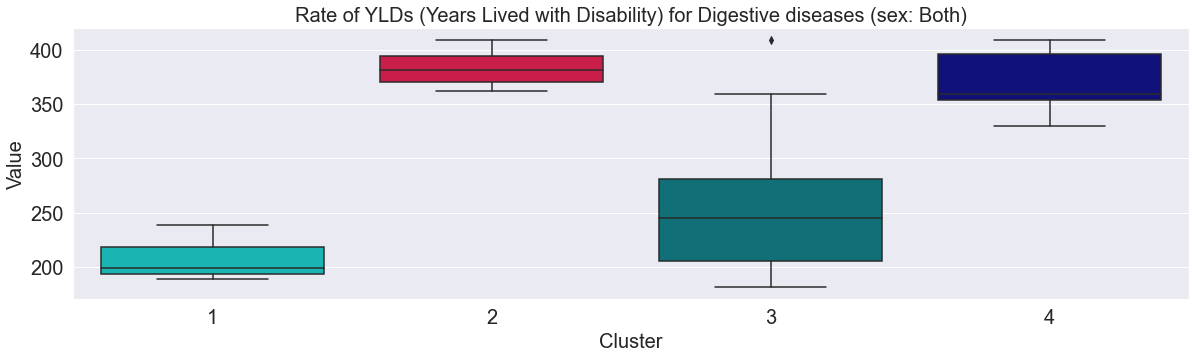

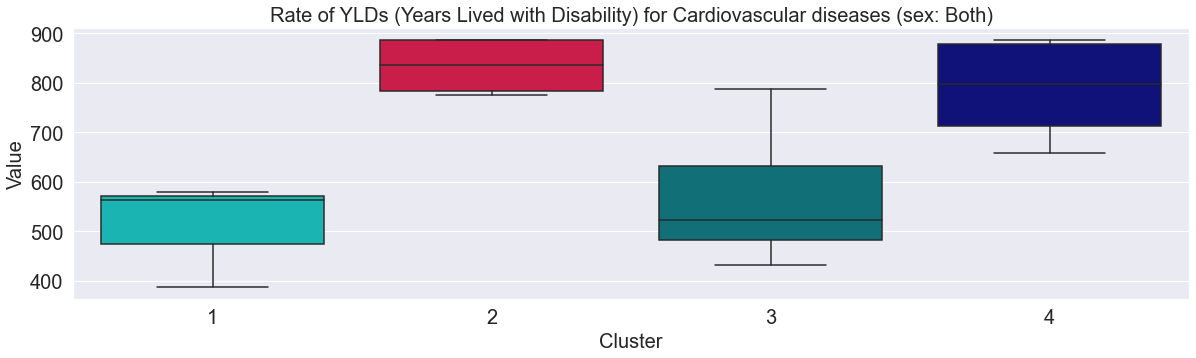

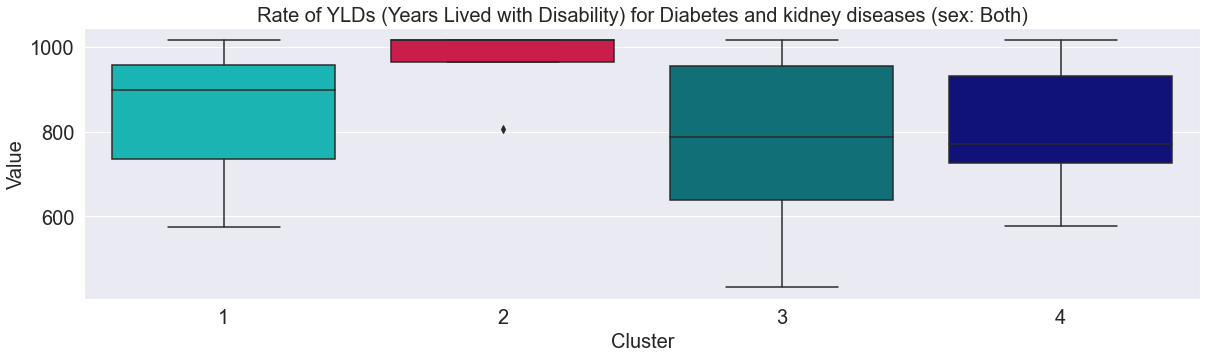

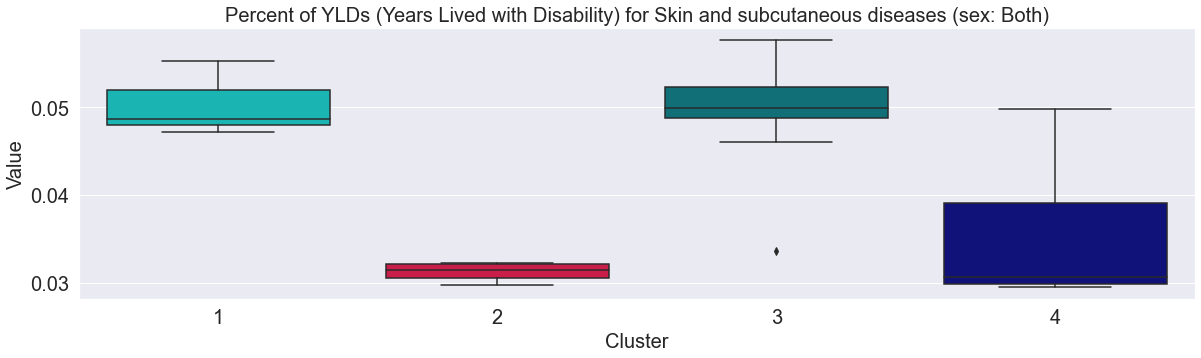

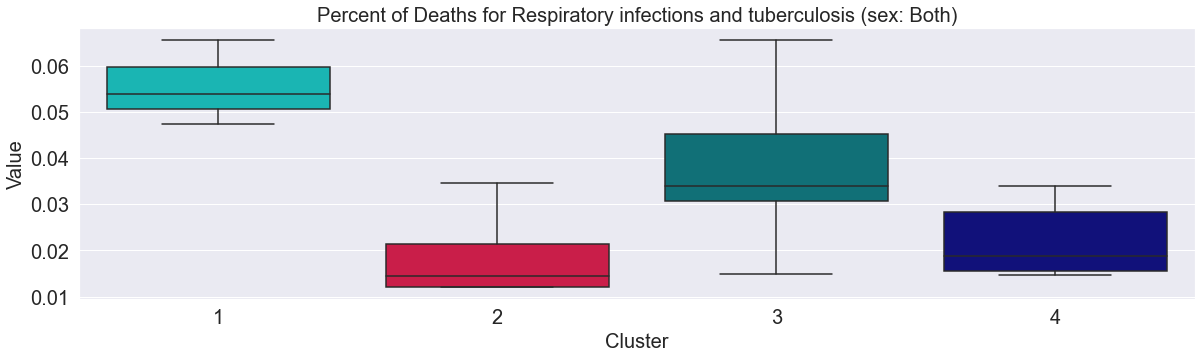

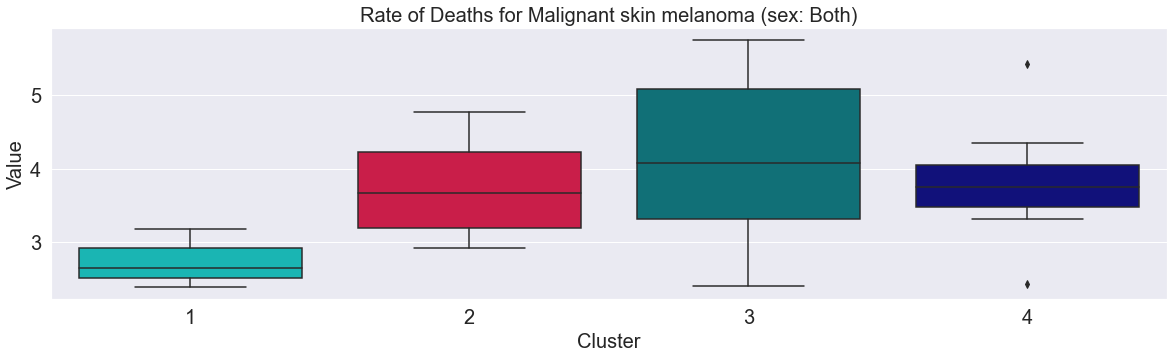

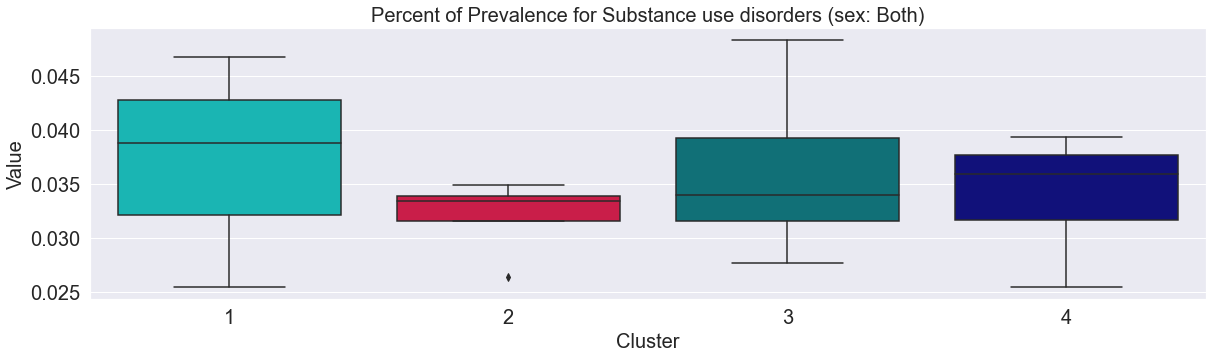

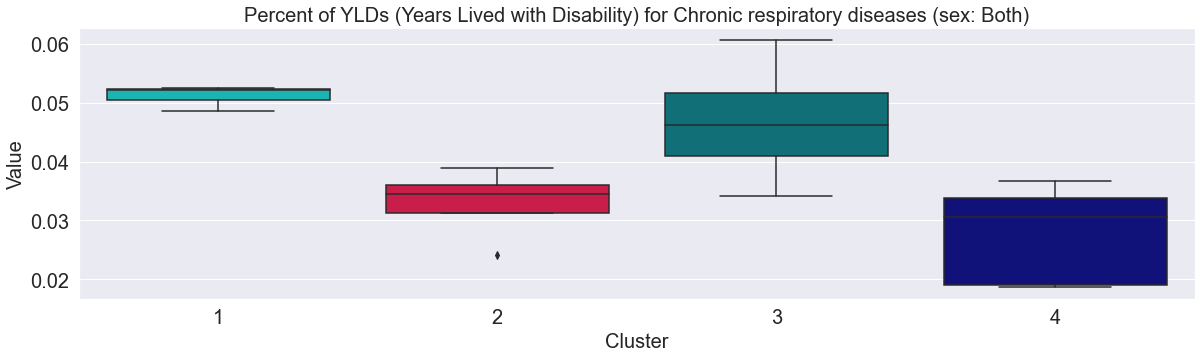

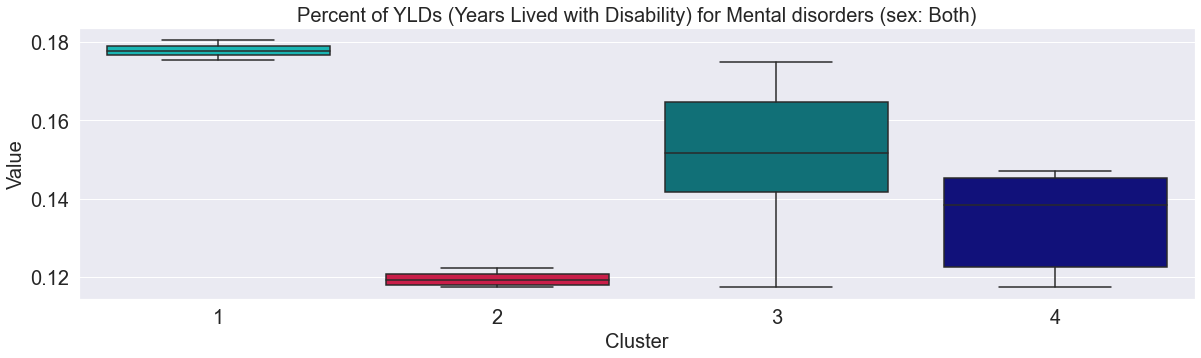

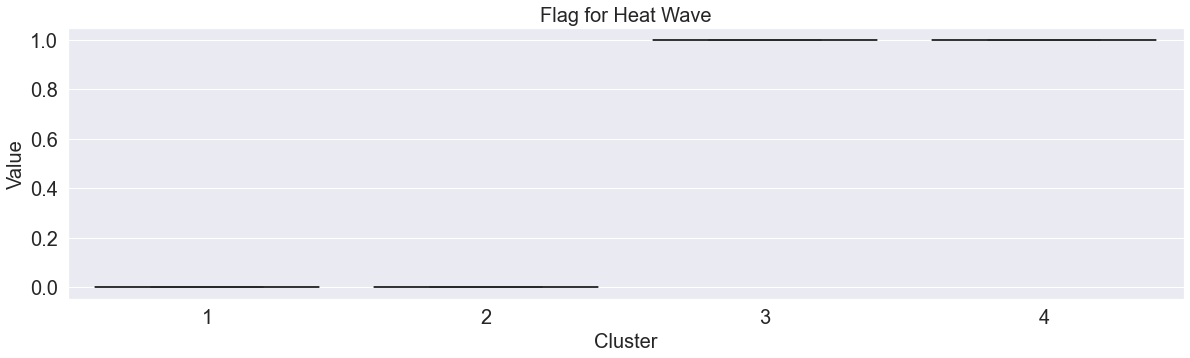

In [24]:
# Loop over variables to plot and save boxplot by cluster
for i in (['Rat-Dea-Bot-Sub_use_dis','Per-YLD-Bot-Res_inf_and_tub','Rat-Pre-Bot-Mal_ski_mel','Num-Dea-Bot-Men_dis','suicide_rate_est_WMEN'
          ,'suicide_rate_high_WMEN','Per-Dea-Bot-Sub_use_dis'] + vars_selected):
  # Plot boxplot
  fig, axes = plt.subplots(ncols=1, figsize = (20,5))
  b = sns.boxplot(x='cluster_KM', y=i, data=selected_data[selected_data['Year'] == 2019], palette = [colors[0],colors[1],colors[2],colors[5]])
  b.axes.set_title(list(features_diccionary[features_diccionary['variable'] == i]['description'])[0], fontsize=20)
  b.set_xlabel("Cluster",fontsize=20)
  b.set_ylabel("Value",fontsize=20)
  b.tick_params(labelsize=20)

  # Save plot
  plt.savefig(output_path + "\\" + 'plots_kmeans_charact' + "\\" + i +'_2019.png')
  plt.show()

In [25]:
before = before_2000.copy()

after_new = selected_data[selected_data['Year'] == 2019].reset_index(drop=True)
after_new.rename(columns={'cluster_KM':'cluster_KM_2019_new'},inplace=True)

cluster_KM_2019_new  1  2  3  4
cluster_KM_2000                
1                    0  0  3  0
2                    3  0  8  0
3                    0  1  1  4
4                    0  3  1  4
--------------------------------------------------
--------------------------------------------------


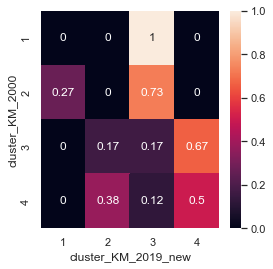

In [26]:
print(pd.crosstab(before.cluster_KM_2000, after_new.cluster_KM_2019_new))
print("--------------------------------------------------")
print("--------------------------------------------------")
plt.subplots(figsize=(4, 4))
sns.heatmap(pd.crosstab(before.cluster_KM_2000, after_new.cluster_KM_2019_new).apply(lambda r: r/r.sum(), axis=1), annot=True)
plt.show()

In [27]:
comp_clusters_new = pd.merge(comp_clusters,
                             after_new[['Country', 'cluster_KM_2019_new']],
                             on='Country', how='inner')

comp_clusters_new

,Country,cluster_KM_2000,cluster_KM_2019,cluster_KM_2019_new
0,Denmark,1,1,3
1,Norway,1,1,3
2,Sweden,1,1,3
3,Netherlands,2,1,3
4,Belgium,2,2,3
5,Switzerland,2,2,3
6,Spain,2,2,3
7,France,2,2,3
8,United Kingdom,2,2,3
9,Greece,2,2,1
